# Customer Satisfaction Prediction

## Objective
This analysis aims to classify our customers as either satisfied or dissatisfied based on their demographic, transactional, and behavioral data.
Users with an NPSChoiceScore below 8 are labeled as dissatisfied.
The accuracy of the analysis is partly relied on the current understanding from the available data and the correctness of the data source.

## Key Findings
- **High Class Overlap**: Significant overlap between satisfied and dissatisfied users leads to poor classification performance, even after feature engineering. 
- **Best Model Performance**: The best model (XGBoost) achieved 58% recall and 12% precision, resulting in a large number of false positives.
- **Gender Imbalance**: A difference in the size of gender groups may indicate a potential bias in the data, raising fairness concerns. 
- **Survey Context segments**: Differences in feature value distributons among the survey context groups indicates different user behaviors across those groups (Galaxus vs. Digitec).
- **Anomalies**: Users with no recent purchases sometimes report high satisfaction, suggesting potential data quality issues.
- **Time Data Gaps**: Inconsistent survey collection across months limits the ability to track temporal satisfaction trends.
- **Early Birds**: Users with half a year membership experience have a higher tendency to be dissatisfied.

## Recommendations
- **Data Expansion**: Collect more granular behavioral data (e.g., browsing activity, abandoned carts), sentiment data, and demographic information to improve classification.
- **Address Biases**: Investigate potential biases related to gender imbalance, which can be addressed in the modeling or data collection phases.
- **Exploring user behavioural segments**: Clustering methods can be used to identify user segments with similar characteristics among different groups. We can consider hybrid/enhanced models for different user segments.
- **Exploring user demographic segments**: One promissing example of this idea is to design an individual dissatisfaction classifier for users with few months of membership.
- **Time-Series and Anomaly Models**: With more temporal data, we could explore time-series models (e.g., LSTM) and anomaly detection techniques to better capture dissatisfaction based on shifts in customer behavior.

## Conclusion
At this stage, our dataset and feature set do not offer sufficient signals to effectively predict customer dissatisfaction. 
To move forward, I recommend improving data collection processes, expanding the range of features, and conducting a thorough review of potential biases in the dataset. 
These changes will be essential for improving model performance and enabling more actionable insights for customer retention.



In [4]:
import pandas as pd
import numpy as np
from scipy.stats import iqr
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
from datetime import datetime
import shap
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
sns.set_style('darkgrid')
pd.options.mode.chained_assignment = None  # default='warn'


# Parameters

In [5]:
sat_thresh = 8 # Threshold on NPSChoiceScore to cut satisfied and dissatisfied classes
random_state = 42 # Random state for reproducibility
outlier_remove = True # Remove outliers
lincorelation_thresh = 0.90 # Threshold for removing linearly corelated features
balanced = False # Balancing the classes

# Data overview

In [6]:
df_orig = pd.read_csv('data/data.csv')
df_orig0 = df_orig.copy()
df_orig.head(10)

C:\Users\bbkho\AppData\Local\Temp\ipykernel_44584\1540455028.py:1: DtypeWarning: Columns (83) have mixed types. Specify dtype option on import or set low_memory=False.
  df_orig = pd.read_csv('data/data.csv')


,PersonId,SurveyType,SurveyContext,SurveyReleaseDate,ResponseCreationDate,NPSChoiceScore,norders__last_month,norders__last_6m,norders__last_year,norders__last_2y,...,ratings_last_2y_mean,ratings_last_2y_median,ratings_last_2y_max,Gender,DateOfBirth,Contact_LanguageId,SendNewsletters,UserInsertDate,IsBlacklisted,CantonId
0,1024099,NPS monatlich,digitec,2018-08-20,2018-08-20,10,0,1,1,4,...,NaN,NaN,NaN,0.0,1966-05-10 00:00:00,1.0,True,2015-01-11 20:00:59.173000,False,11.0
1,1851595,NPS monatlich,digitec,2018-08-20,2018-08-20,10,0,0,0,0,...,NaN,NaN,NaN,1.0,1968-07-07 00:00:00,1.0,False,0,False,8.0
2,919068,NPS monatlich,digitec,2018-08-20,2018-08-20,9,0,2,3,4,...,NaN,NaN,NaN,1.0,1991-04-17 00:00:00,1.0,True,2014-11-27 17:58:15.227000,False,16.0
3,1311507,NPS monatlich,Galaxus,2018-08-20,2018-08-20,8,0,0,0,0,...,NaN,NaN,NaN,0.0,0,1.0,False,2015-08-14 08:15:42.030000,False,4.0
4,2323986,NPS monatlich,digitec,2018-08-20,2018-08-20,10,0,0,0,1,...,NaN,NaN,NaN,0.0,1949-07-29 00:00:00,1.0,True,2017-07-15 12:02:03.800000,False,5.0
5,729237,NPS monatlich,Galaxus,2018-08-20,2018-08-20,10,0,2,2,3,...,NaN,NaN,NaN,0.0,1987-11-24 00:00:00,1.0,True,2014-08-26 18:08:05.090000,False,4.0
6,915383,NPS monatlich,Galaxus,2018-08-20,2018-08-20,9,0,0,0,0,...,NaN,NaN,NaN,0.0,1967-12-12 00:00:00,1.0,True,2014-11-26 12:06:24.727000,False,8.0
7,909032,NPS monatlich,digitec,2018-08-20,2018-08-20,9,0,1,1,3,...,5.0,5.0,5.0,0.0,1976-03-05 00:00:00,1.0,True,2014-11-23 22:29:53.757000,False,16.0
8,925988,NPS monatlich,digitec,2018-08-20,2018-08-20,9,0,0,3,3,...,NaN,NaN,NaN,0.0,1966-09-17 00:00:00,1.0,True,2014-11-30 22:49:00.967000,False,16.0
9,2303641,NPS monatlich,digitec,2018-08-20,2018-08-20,8,0,0,0,0,...,NaN,NaN,NaN,0.0,1992-02-14 00:00:00,1.0,True,2017-06-29 16:16:55.260000,False,22.0


A summarized overview of all the existing columns, data types, and missing values:

In [7]:
for ctype in ['number', 'object', 'bool', 'category']:
    print(f'Number of columns of type {ctype}: ',len(df_orig.select_dtypes(ctype).columns))
    if len(df_orig.select_dtypes(ctype).columns) < 15:
        print(df_orig.select_dtypes(ctype).columns.tolist(),'\n')
    else:
        print(df_orig.select_dtypes(ctype).columns[:15],'\n', '...')

Number of columns of type number:  75
Index(['PersonId', 'NPSChoiceScore', 'norders__last_month', 'norders__last_6m',
       'norders__last_year', 'norders__last_2y', 'norders_galaxus__last_month',
       'norders_galaxus__last_6m', 'norders_galaxus__last_year',
       'norders_galaxus__last_2y', 'norders_digitec__last_month',
       'norders_digitec__last_6m', 'norders_digitec__last_year',
       'norders_digitec__last_2y',
       'norderpositions_directdelivery__last_month'],
      dtype='object') 
 ...
Number of columns of type object:  7
['SurveyType', 'SurveyContext', 'SurveyReleaseDate', 'ResponseCreationDate', 'DateOfBirth', 'UserInsertDate', 'CantonId'] 

Number of columns of type bool:  2
['SendNewsletters', 'IsBlacklisted'] 

Number of columns of type category:  0
[] 



Statistical overview of numerical features:

In [8]:
df_orig.describe()

,PersonId,NPSChoiceScore,norders__last_month,norders__last_6m,norders__last_year,norders__last_2y,norders_galaxus__last_month,norders_galaxus__last_6m,norders_galaxus__last_year,norders_galaxus__last_2y,...,session_duration_last_year_median,session_duration_last_year_mean,session_duration_last_year_max,ratings_last_2y_count,ratings_last_2y_min,ratings_last_2y_mean,ratings_last_2y_median,ratings_last_2y_max,Gender,Contact_LanguageId
count,6.177200e+04,61772.000000,61772.000000,61772.000000,61772.000000,61772.000000,61772.000000,61772.000000,61772.000000,61772.000000,...,46570.000000,46570.000000,4.657000e+04,61772.000000,14706.000000,14706.000000,14706.000000,14706.000000,61757.000000,61757.000000
mean,1.392071e+06,8.752315,0.867157,3.899615,6.525724,10.986547,0.426714,1.869439,3.054863,4.905313,...,113.079547,446.716502,6.579527e+03,0.929062,3.805386,4.294066,4.369441,4.560384,0.220024,1.375925
std,1.066106e+06,1.613193,1.121072,4.445921,7.834258,13.521114,0.819194,3.158210,5.462364,8.846992,...,3562.096456,4200.104457,3.822314e+04,3.976773,1.363761,0.985201,1.020075,0.967365,0.414266,0.784762
min,2.471400e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,5.346698e+05,8.000000,0.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,1.100000,7.000000e+00,0.000000,3.000000,4.000000,4.000000,5.000000,0.000000,1.000000
50%,9.471855e+05,9.000000,1.000000,3.000000,4.000000,7.000000,0.000000,1.000000,1.000000,2.000000,...,0.000000,64.000000,3.590000e+02,0.000000,4.000000,4.666667,5.000000,5.000000,0.000000,1.000000
75%,2.126241e+06,10.000000,1.000000,5.000000,8.000000,14.000000,1.000000,2.000000,4.000000,6.000000,...,0.000000,278.213043,2.715750e+03,0.000000,5.000000,5.000000,5.000000,5.000000,0.000000,1.000000
max,4.667983e+06,10.000000,27.000000,272.000000,551.000000,696.000000,27.000000,271.000000,550.000000,695.000000,...,478136.000000,478136.000000,1.312750e+06,310.000000,5.000000,5.000000,5.000000,5.000000,1.000000,4.000000


# Data cleaning and preprocessing

Searching for duplicated users:

In [9]:
df_orig[df_orig.duplicated(subset='PersonId')]

,PersonId,SurveyType,SurveyContext,SurveyReleaseDate,ResponseCreationDate,NPSChoiceScore,norders__last_month,norders__last_6m,norders__last_year,norders__last_2y,...,ratings_last_2y_mean,ratings_last_2y_median,ratings_last_2y_max,Gender,DateOfBirth,Contact_LanguageId,SendNewsletters,UserInsertDate,IsBlacklisted,CantonId


Distribution of NPSChoiceScore

<Axes: xlabel='NPSChoiceScore', ylabel='count'>

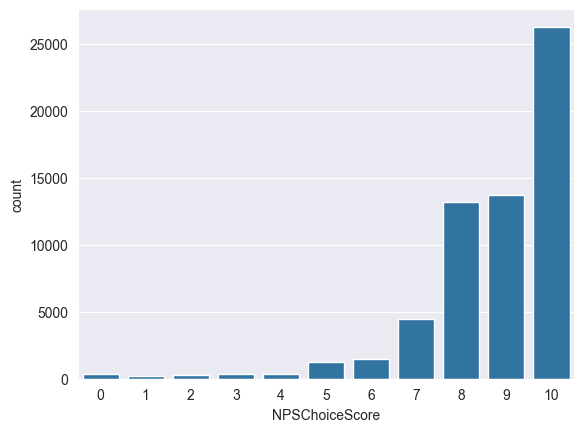

In [10]:
sns.countplot(df_orig, x = 'NPSChoiceScore')

We also have unbalanced Gender categories:

<Axes: xlabel='Gender', ylabel='count'>

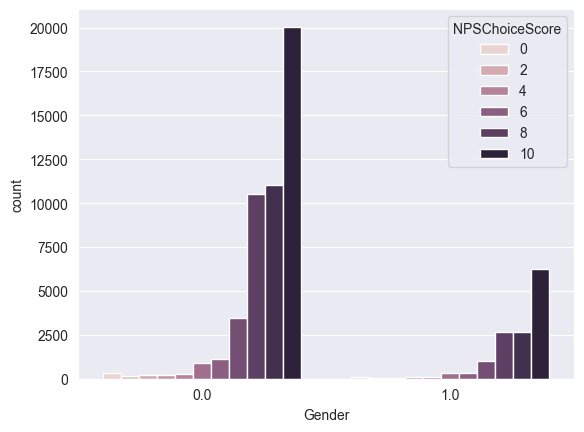

In [11]:
sns.countplot(df_orig, x = 'Gender', hue = 'NPSChoiceScore')

## Convert NPSChoiceScore to binary categories

In [12]:
df_orig = df_orig.dropna(subset='NPSChoiceScore')
# print(df_orig['NPSChoiceScore'].value_counts(sort=True))
df_orig['NPS_cat'] = df_orig['NPSChoiceScore'].apply(lambda x: 1 if x<sat_thresh else 0)
print('\n\nAny nan values in NPS_cat:\n',len(df_orig[df_orig['NPS_cat'].isna()]))
print('\nThe ratio of the classes:\n',df_orig['NPS_cat'].value_counts(sort=True,normalize=True))
print('\nThe size of the classes:\n',df_orig['NPS_cat'].value_counts(sort=True))
df_orig[['NPS_cat', 'NPSChoiceScore']].value_counts(sort=True)



Any nan values in NPS_cat:
 0

The ratio of the classes:
 NPS_cat
0    0.860665
1    0.139335
Name: proportion, dtype: float64

The size of the classes:
 NPS_cat
0    53165
1     8607
Name: count, dtype: int64


NPS_cat  NPSChoiceScore
0        10                26281
         9                 13696
         8                 13188
1        7                  4473
         6                  1450
         5                  1212
         0                   386
         4                   336
         3                   324
         2                   257
         1                   169
Name: count, dtype: int64

<Axes: xlabel='NPSChoiceScore', ylabel='count'>

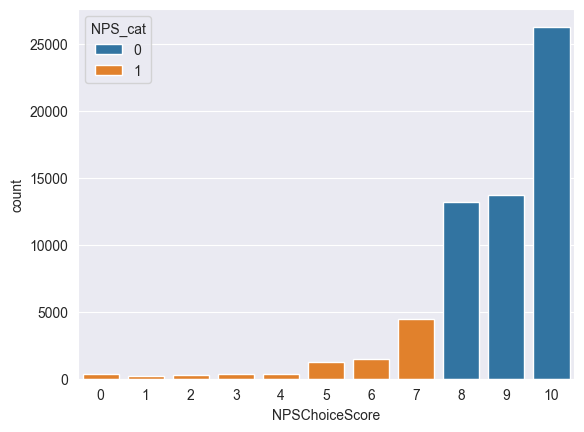

In [13]:
sns.countplot(df_orig, x = 'NPSChoiceScore', hue = 'NPS_cat')

## Boolean columns:
The two columns of SendNewsletters and IsBlacklisted are not relevant to the task.

In [14]:
print(df_orig.select_dtypes('bool').info())
print(df_orig.select_dtypes('bool').head(5))
df_orig = df_orig.drop(columns=df_orig.select_dtypes('bool').columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61772 entries, 0 to 61771
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   SendNewsletters  61772 non-null  bool 
 1   IsBlacklisted    61772 non-null  bool 
dtypes: bool(2)
memory usage: 120.8 KB
None
   SendNewsletters  IsBlacklisted
0             True          False
1            False          False
2             True          False
3            False          False
4             True          False


## non-numerical columns:
- ResponseCreationDate will be used as the survey date.
- SurveyReleaseDate will be dropped as it is redundant with ResponseCreationDate.
- UserInsertDate will be used to calculate membership duration.
- DateOfBirth will be used to calculate customer age.
- SurveyType and SurveyContext will not be used as input features to the model as they are not available before doing a survey.
However, we'll investigate their relevance to segmentation of users' behavioural patterns. 

In [15]:
print(df_orig.select_dtypes('object').info())
df_orig.select_dtypes('object').head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61772 entries, 0 to 61771
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   SurveyType            61772 non-null  object
 1   SurveyContext         61772 non-null  object
 2   SurveyReleaseDate     61772 non-null  object
 3   ResponseCreationDate  61772 non-null  object
 4   DateOfBirth           61757 non-null  object
 5   UserInsertDate        61757 non-null  object
 6   CantonId              61125 non-null  object
dtypes: object(7)
memory usage: 3.3+ MB
None


,SurveyType,SurveyContext,SurveyReleaseDate,ResponseCreationDate,DateOfBirth,UserInsertDate,CantonId
0,NPS monatlich,digitec,2018-08-20,2018-08-20,1966-05-10 00:00:00,2015-01-11 20:00:59.173000,11.0
1,NPS monatlich,digitec,2018-08-20,2018-08-20,1968-07-07 00:00:00,0,8.0
2,NPS monatlich,digitec,2018-08-20,2018-08-20,1991-04-17 00:00:00,2014-11-27 17:58:15.227000,16.0
3,NPS monatlich,Galaxus,2018-08-20,2018-08-20,0,2015-08-14 08:15:42.030000,4.0
4,NPS monatlich,digitec,2018-08-20,2018-08-20,1949-07-29 00:00:00,2017-07-15 12:02:03.800000,5.0


The distribution of NPS surveys among SurveyType groups is not similar. 
But score categories are similarly distributed within each survey type group.
My assumption is the difference between the survey types is only the scale and frequency of user participations.


NPS_cat,0,1
SurveyType,,
NPS gross,0.859371,0.140629
NPS klein,0.863913,0.136087
NPS monatlich,0.865169,0.134831


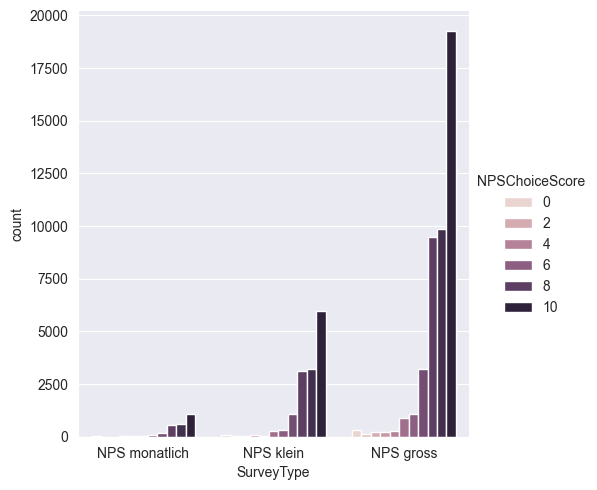

In [16]:
sns.catplot(kind = 'count', data=df_orig, x='SurveyType', hue='NPSChoiceScore')
survey_class_counts = pd.crosstab(df_orig['SurveyType'], df_orig['NPS_cat'])
survey_class_proportions = survey_class_counts.div(survey_class_counts.sum(axis=1), axis=0)
survey_class_proportions

Distribution of NPS scores among SurveyContext groups is similar.

I'd stil have a closer look at the nature and relevance of the survey types. 
They may still influence the score the user puts in the survey.

NPS_cat,0,1
SurveyContext,,
Galaxus,0.848320,0.151680
digitec,0.873873,0.126127


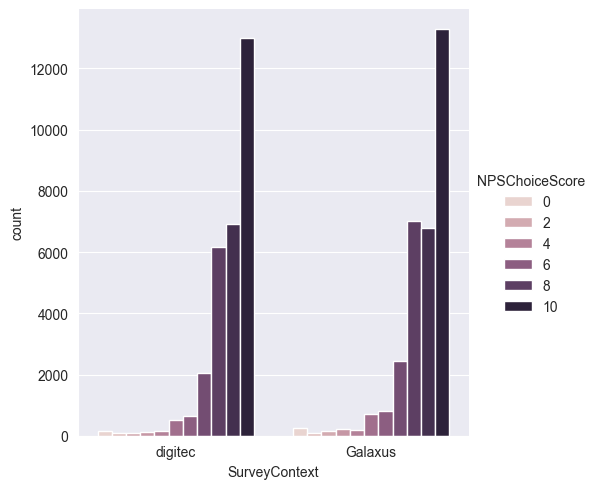

In [17]:
sns.catplot(kind = 'count', data=df_orig, x='SurveyContext', hue='NPSChoiceScore')
survey_class_counts = pd.crosstab(df_orig['SurveyContext'], df_orig['NPS_cat'])
survey_class_proportions = survey_class_counts.div(survey_class_counts.sum(axis=1), axis=0)
survey_class_proportions

Converting dates to datetime format:

In [18]:
#  convert to datetime
print('Data size before conversion:',len(df_orig))
date_columns = ['DateOfBirth', 'ResponseCreationDate', 'SurveyReleaseDate']
for col in date_columns:
  df_orig[col] = pd.to_datetime(df_orig[col] , errors = 'coerce')
  print('Null values in', col, 'after conversion:', df_orig[col].isnull().sum())

Data size before conversion: 61772
Null values in DateOfBirth after conversion: 1576
Null values in ResponseCreationDate after conversion: 0
Null values in SurveyReleaseDate after conversion: 0


Calculating the age of the customer:

Some DateOfBirth values are entered as zero. I replaced them with the median of customer ages.

In [19]:
df_orig['Age'] = \
    ((df_orig['ResponseCreationDate'] - df_orig['DateOfBirth'])/ 365.25).dt.days
df_orig['Age'] = df_orig['Age'].fillna(df_orig['Age'].median()).astype(int)

df_orig['Age'].describe()

count    61772.000000
mean        42.128731
std         14.313882
min          7.000000
25%         31.000000
50%         40.000000
75%         52.000000
max        125.000000
Name: Age, dtype: float64

Fixing minimum and outlier age values:
- The minimum age is consider 18 as the base rule in Galaxus shop.
- The outliers (large values in this case) are removed due to their low numbers.

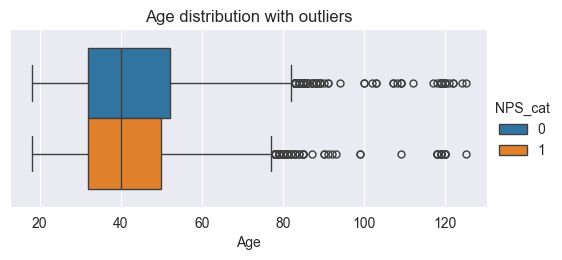

NPS_cat
0    1339
1     205
Name: count, dtype: int64
Outliers ratio: 0.025274599355039368
Data size after removing Age outliers: NPS_cat
0    51232
1     8313
Name: count, dtype: int64


Text(0.5, 1.0, 'Age distribution without outliers')

<Figure size 640x480 with 0 Axes>

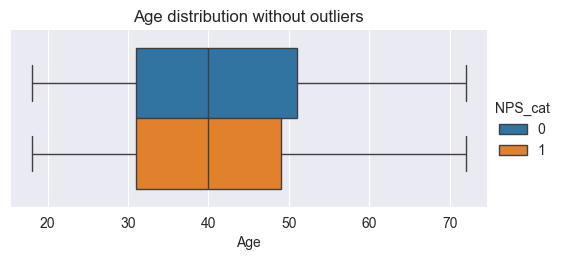

In [20]:
# Fixing minimum age
"""
Customers confirm compliance with the legal provisions for all product orders with a minimum age requirement of 18
 (particularly for alcohol and tobacco products)"""
df_orig = df_orig[df_orig['Age']>=18]

# Removing Age outliers
sns.catplot(df_orig, x='Age', hue = 'NPS_cat', kind = 'box', height=2.5, aspect=2)
plt.title('Age distribution with outliers')
plt.show()

IQR = iqr(df_orig['Age'])
low_bound = df_orig['Age'].mean() - 1.5*IQR
high_bound = df_orig['Age'].mean() + 1.5*IQR
index_outliers = (df_orig['Age'] < low_bound) | (df_orig['Age'] > high_bound)
df_out = df_orig[index_outliers]
print(df_out['NPS_cat'].value_counts())
print('Outliers ratio:',len(df_out)/len(df_orig))
if outlier_remove == True:
  df_orig = df_orig[~index_outliers]

print('Data size after removing Age outliers:',df_orig['NPS_cat'].value_counts())

plt.clf()
sns.catplot(df_orig, x='Age', hue = 'NPS_cat', kind = 'box', height=2.5, aspect=2)
plt.title('Age distribution without outliers')

NPS scores have similar age distributions:

count    59545.000000
mean        41.500008
std         13.013701
min         18.000000
25%         31.000000
50%         40.000000
75%         51.000000
max         72.000000
Name: Age, dtype: float64

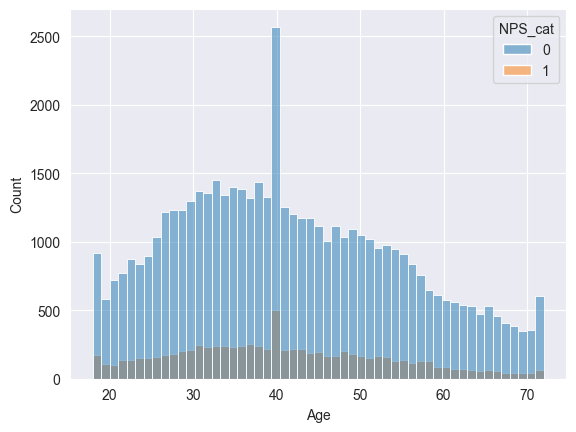

In [21]:
sns.histplot(data=df_orig, x = 'Age', hue = 'NPS_cat')
df_orig['Age'].describe()

SurveyReleaseDate is dropped due to its redundancy with ResponseCreationDate:

In [22]:
print((df_orig['ResponseCreationDate'] - df_orig['SurveyReleaseDate']).value_counts(sort=True))
df_orig.drop(columns=['SurveyReleaseDate'], inplace=True)

0 days     30943
1 days     16419
2 days      6079
3 days      2819
4 days      1628
5 days       961
6 days       495
7 days       136
8 days        32
9 days        28
10 days        5
Name: count, dtype: int64


Membership duration:
- Some wrong date formats and 0 values exists in UserInsertDate which are either corrected or removed.
- Users with less than a month of membership till survey date are also removed.


In [23]:
# Convering UserInsertDate_date to datetime format
df_orig['UserInsertDate_date'] = pd.to_datetime(df_orig['UserInsertDate'], errors = 'coerce')

# Correcting wrong date formats
invalid_cases = df_orig['UserInsertDate_date'].isna()
df_invalid_cases = df_orig[invalid_cases]['UserInsertDate']
df_orig.loc[invalid_cases,'UserInsertDate_date'] = pd.to_datetime(df_invalid_cases , format='%Y-%m-%d %H:%M:%S', errors = 'coerce')
print(df_orig[df_orig['UserInsertDate_date'].isna()]['NPS_cat'].value_counts(sort=True))
df_orig['UserInsertDate'] = df_orig['UserInsertDate_date']
df_orig = df_orig.drop(columns=['UserInsertDate_date'])
df_orig = df_orig[~df_orig['UserInsertDate'].isna()]
df_orig[df_orig['UserInsertDate'].isna()]['NPS_cat'].value_counts(sort=True)

# removing user with less than a month membership till survey date
df_orig = df_orig[df_orig['ResponseCreationDate'] - df_orig['UserInsertDate'] >= pd.Timedelta(days=30)]
print('Length of modifed dataset',len(df_orig))

# Calculating membership length
df_orig['Membership_length'] = (df_orig['ResponseCreationDate'] - df_orig['UserInsertDate'])\
  /pd.Timedelta(days=365.25)
df_orig['Membership_length'] = df_orig['Membership_length'].round(1)

print('\nStatistical description of membership length:\n',df_orig['Membership_length'].describe())

NPS_cat
0    43
1     4
Name: count, dtype: int64
Length of modifed dataset 57277

Statistical description of membership length:
 count    57277.000000
mean         4.385383
std          2.375838
min          0.100000
25%          2.600000
50%          4.500000
75%          5.900000
max         11.100000
Name: Membership_length, dtype: float64


Users with half a year membership experience have a higher tendency to be dissatisfied. 
Therefore it is advisable to investigate designing an individual model for those users.

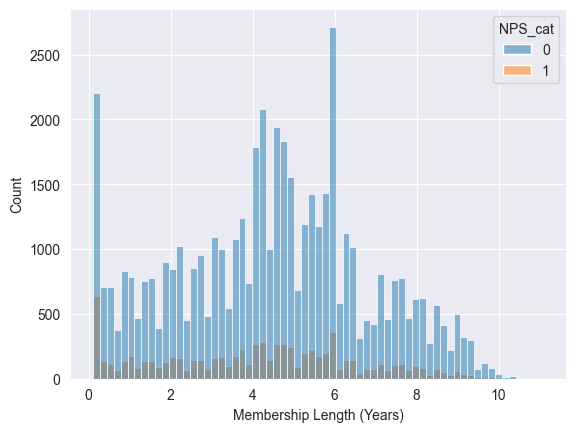

Text(0.5, 0, 'Membership Length (Years)')

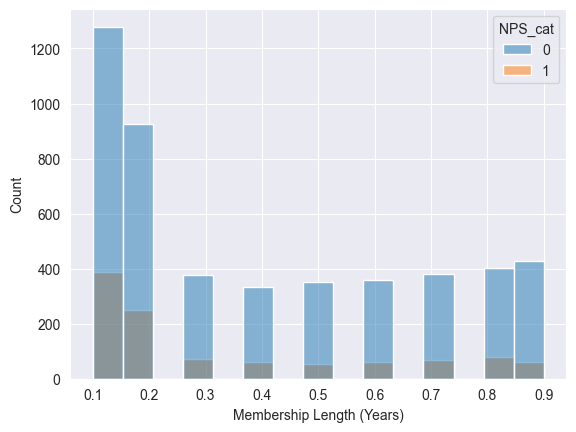

In [24]:
sns.histplot(df_orig, x='Membership_length', hue = 'NPS_cat')
plt.xlabel('Membership Length (Years)')
plt.show()
plt.close()
sns.histplot(df_orig[df_orig['Membership_length']<1], x='Membership_length', hue = 'NPS_cat')
plt.xlabel('Membership Length (Years)')

CantonId is also converted to a numeric column.
Missing values are added to a new group.

Unique cantons list:
 [11.0 16.0 4.0 5.0 8.0 22.0 10.0 25.0 6.0 3.0 1.0 12.0 20.0 18.0 nan 21.0
 26.0 2.0 23.0 15.0 14.0 9.0 17.0 24.0 19.0 13.0 7.0 '9' '11' '4' '21'
 '16' '1' '3' '8' '12' '5' '15' '2' '25' '17' '10' '19' '23' '13' '6' '20'
 '7' '24' '22' '18' '14' '26' 'Zürich' 'Leuggern']


Unique numerical cantons list:
 [11. 16.  4.  5.  8. 22. 10. 25.  6.  3.  1. 12. 20. 18.  0. 21. 26.  2.
 23. 15. 14.  9. 17. 24. 19. 13.  7.]


<Axes: xlabel='CantonId', ylabel='count'>

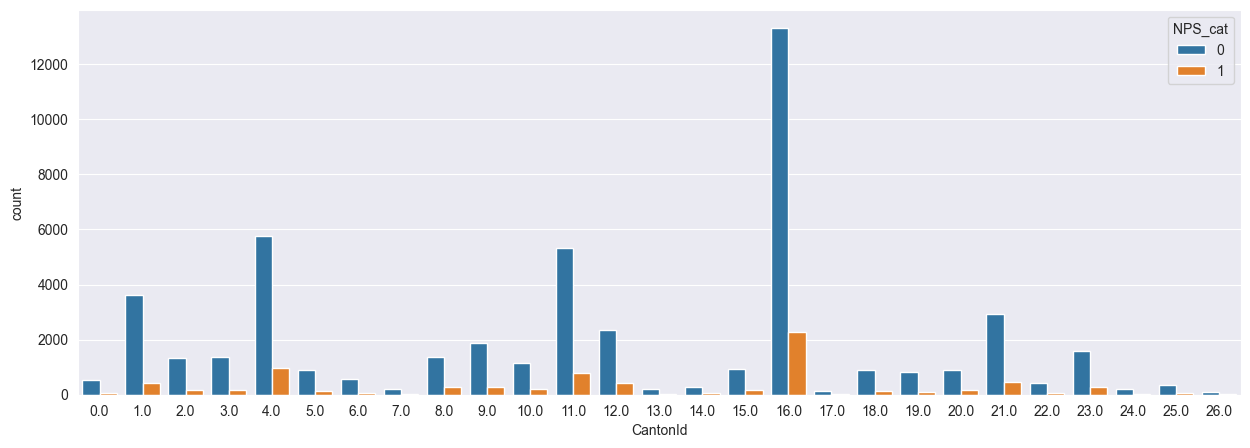

In [25]:
print('Unique cantons list:\n',df_orig['CantonId'].unique())
df_orig = df_orig[df_orig['CantonId'] != 'Leuggern']

# I assumed 16 is related to Zurich
df_orig.loc[df_orig['CantonId']=='Zürich','CantonId'] = 16
df_orig['CantonId'] = df_orig['CantonId'].apply(lambda x: int(x) if str(x).isdigit() else x)
df_orig['CantonId'] = df_orig['CantonId'].fillna(0)
print('\n\nUnique numerical cantons list:\n', df_orig['CantonId'].unique())

fig = plt.figure(figsize=(15, 5))
sns.countplot(df_orig, x='CantonId', hue = 'NPS_cat')

Although we have more surveyes in Cantons 16, 4, and 11, the ratio of dissatisfied and satisfied users are similar between cantons.

In [26]:
canton_class_counts = pd.crosstab(df_orig['CantonId'], df_orig['NPS_cat'])
canton_class_proportions = canton_class_counts.div(canton_class_counts.sum(axis=1), axis=0)\
    .reset_index(drop=True).rename(columns = {0:'Satisfied', 1:'Dissatisfied'})
print('The statistics of the dissatisfied class ratio over all cantons:')
canton_class_proportions['Dissatisfied'].describe()

The statistics of the dissatisfied class ratio over all cantons:


count    27.000000
mean      0.131863
std       0.018296
min       0.103004
25%       0.116805
50%       0.130392
75%       0.144911
max       0.164628
Name: Dissatisfied, dtype: float64

## Numerical columns:
- Numerical columns are mostly associated with the users purchase behavior and their interactions with the platform.

- `
norders__X >= norders_galaxus__X + norders_digitec__X
`, i.e. value of norders includes both orders from Galaxus and Digitec and maybe also from another channel.

- I do not have any information about the time window of these features. So, I treat them as they are:
  - ndelivery_option_X
  - npayments_option_X


### Handling missing values in the numerical columns:
- The columns with missing values are related to delivery/payment options, delivery/session duraton and ratings.
- We treat the missing values of these columns differently depending on the size of missing values and the information each column carrries.
- The missing values matrix helps us visually observe connections and patterns of missing values accross different columns of the data.


<class 'pandas.core.frame.DataFrame'>
Index: 57276 entries, 14321 to 6
Data columns (total 21 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ndelivery_option_1                  55337 non-null  float64
 1   ndelivery_option_2                  55337 non-null  float64
 2   ndelivery_option_17                 55337 non-null  float64
 3   ndelivery_option_22                 55337 non-null  float64
 4   ndelivery_option_24                 55337 non-null  float64
 5   ndelivery_option_26                 55337 non-null  float64
 6   days_since_last_order               55873 non-null  float64
 7   days_since_last_delivery            55873 non-null  float64
 8   delivery_duration_last_year_min     55337 non-null  float64
 9   delivery_duration_last_year_median  55337 non-null  float64
 10  delivery_duration_last_year_mean    55337 non-null  float64
 11  delivery_duration_last_year_max     55337 non-

Text(0.5, 1.0, 'Missing values heatmap')

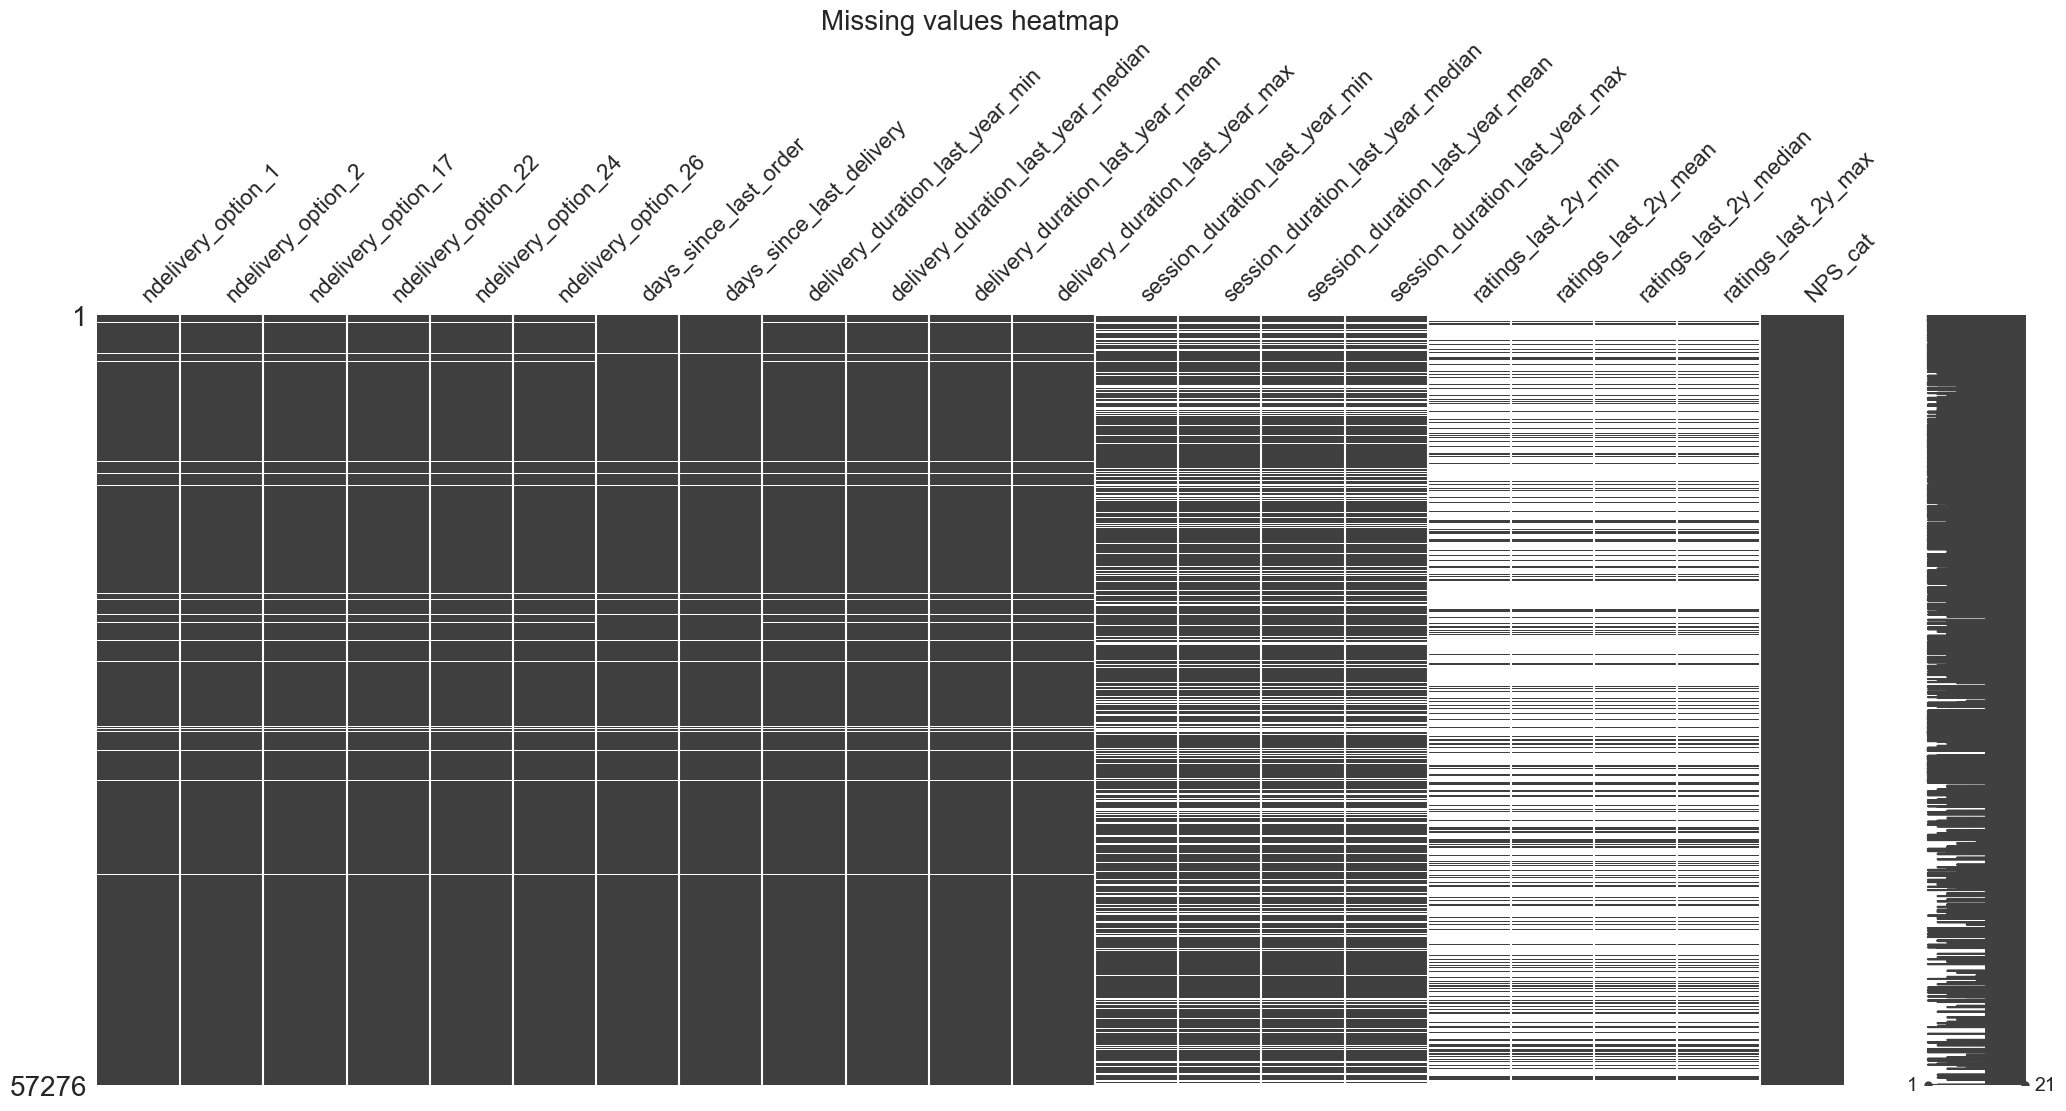

In [27]:
nan_columns = df_orig.select_dtypes('number').isna().any()
nan_columns = nan_columns[nan_columns==True]
df_missing = df_orig[nan_columns.index.to_list()+['NPS_cat']]
df_missing = df_missing.sort_values('NPS_cat', ascending=False)
print(df_missing.info())
msno.matrix(df_missing)
plt.title('Missing values heatmap', fontsize=20)

The rating columns have too many missing values. Therefore, we drop them.

In [28]:
# dropinf rating columns
print('Size of original dataset:\n', len(df_orig))
cols = [col for col in df_orig.columns if ('rating' in col.lower())&('count' not in col.lower())]
print(df_orig[cols].isna().sum())
df_orig.drop(columns=cols, inplace=True)

Size of original dataset:
 57276
ratings_last_2y_min       43275
ratings_last_2y_mean      43275
ratings_last_2y_median    43275
ratings_last_2y_max       43275
dtype: int64


We impute missing values of session duration columns by median of those columns over all users:

In [29]:
miss_cols = [col for col in df_orig.columns if 'session_duration' in col]
print(miss_cols)
for col in miss_cols:
  df_orig[col] = df_orig[col].fillna(df_orig[col].median())

fig = plt.figure(figsize=(15, 5))
df_orig[miss_cols].info()
df_orig[miss_cols].describe()

['session_duration_last_year_min', 'session_duration_last_year_median', 'session_duration_last_year_mean', 'session_duration_last_year_max']
<class 'pandas.core.frame.DataFrame'>
Index: 57276 entries, 0 to 61771
Data columns (total 4 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   session_duration_last_year_min     57276 non-null  float64
 1   session_duration_last_year_median  57276 non-null  float64
 2   session_duration_last_year_mean    57276 non-null  float64
 3   session_duration_last_year_max     57276 non-null  float64
dtypes: float64(4)
memory usage: 2.2 MB


,session_duration_last_year_min,session_duration_last_year_median,session_duration_last_year_mean,session_duration_last_year_max
count,57276.000000,57276.000000,57276.000000,5.727600e+04
mean,32.242283,84.885528,363.438784,5.307220e+03
std,1633.913429,3147.684161,3733.327244,3.440597e+04
min,-1247.000000,0.000000,0.000000,0.000000e+00
25%,0.000000,0.000000,11.853383,5.000000e+01
50%,0.000000,0.000000,65.000000,3.720000e+02
75%,0.000000,0.000000,190.575360,1.597000e+03
max,328190.000000,478136.000000,478136.000000,1.312750e+06


<Figure size 1500x500 with 0 Axes>

As an interesting finding, we can see that session duration is not normally distributed. 
Assuming the session durations are in minutes, the majority of users have session duration of 0 or 60 minutes (or in seconds).

session_duration_last_year_mean
65.0    12912
0.0     10606
8.0        71
9.0        70
Name: count, dtype: int64

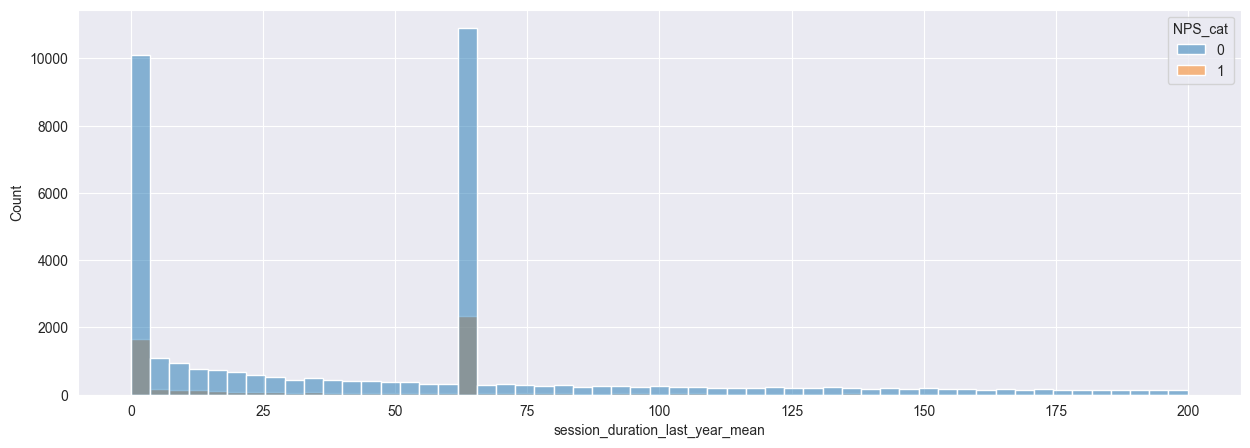

In [30]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(df_orig[df_orig['session_duration_last_year_mean']<200], x='session_duration_last_year_mean', hue = 'NPS_cat')
df_orig['session_duration_last_year_mean'].value_counts(sort=True).iloc[0:4]


Regarding *npayments_option_x* or *ndelivery_option_x* columns, we fill the missing values with 0.
This is based on an assumption that a nan value indicates that such options were not used by the customer.


In [31]:
cols = [col for col in df_orig.columns if 'option' in col]
df_orig[cols] = df_orig[cols].fillna(0)
df_orig[cols].info()

<class 'pandas.core.frame.DataFrame'>
Index: 57276 entries, 0 to 61771
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   npayments_option_2   57276 non-null  int64  
 1   npayments_option_3   57276 non-null  int64  
 2   npayments_option_4   57276 non-null  int64  
 3   npayments_option_5   57276 non-null  int64  
 4   npayments_option_7   57276 non-null  int64  
 5   npayments_option_10  57276 non-null  int64  
 6   npayments_option_17  57276 non-null  int64  
 7   npayments_option_18  57276 non-null  int64  
 8   npayments_option_20  57276 non-null  int64  
 9   npayments_option_24  57276 non-null  int64  
 10  npayments_option_27  57276 non-null  int64  
 11  npayments_option_28  57276 non-null  int64  
 12  npayments_option_29  57276 non-null  int64  
 13  ndelivery_option_1   57276 non-null  float64
 14  ndelivery_option_2   57276 non-null  float64
 15  ndelivery_option_17  57276 non-null  floa

,npayments_option_2,npayments_option_3,npayments_option_4,npayments_option_5,npayments_option_7,npayments_option_10,npayments_option_17,npayments_option_18,npayments_option_20,npayments_option_24,npayments_option_27,npayments_option_28,npayments_option_29,ndelivery_option_1,ndelivery_option_2,ndelivery_option_17,ndelivery_option_22,ndelivery_option_24,ndelivery_option_26
count,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.00000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000,57276.000000
mean,0.559676,1.719638,0.084067,0.585795,0.861687,0.285076,0.029943,0.098505,0.411167,0.003701,0.03766,1.326716,0.001100,5.604651,1.098331,0.003474,0.022854,0.103324,0.002968
std,2.899260,4.047945,0.676218,2.691894,2.965162,1.522141,0.347584,0.493984,1.938140,0.177239,0.61436,3.541434,0.059816,7.123180,3.371916,0.060596,0.201396,0.642079,0.072794
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,7.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,525.000000,176.000000,39.000000,167.000000,125.000000,58.000000,14.000000,24.000000,123.000000,21.000000,33.00000,190.000000,11.000000,551.000000,135.000000,2.000000,15.000000,46.000000,6.000000


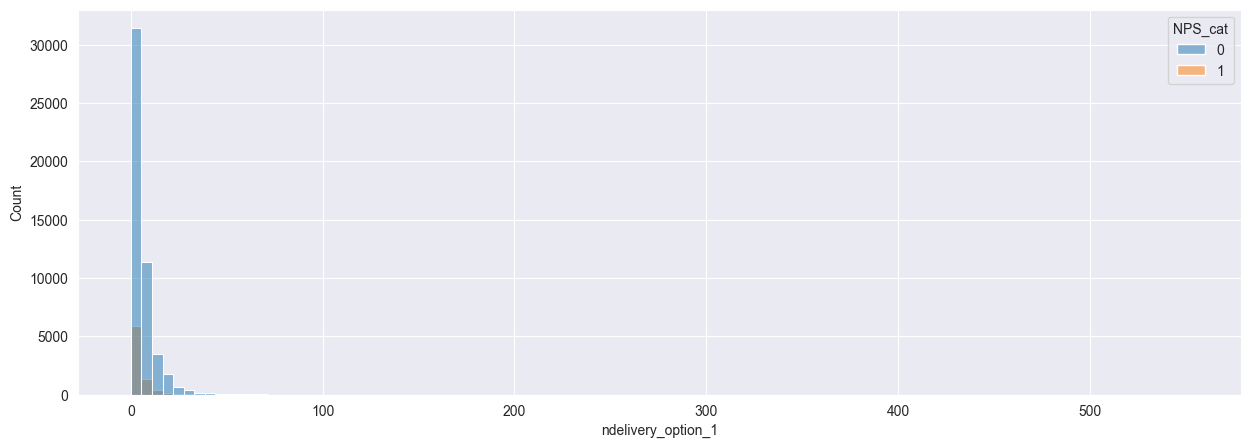

In [32]:
fig = plt.figure(figsize=(15, 5))
sns.histplot(df_orig, x='ndelivery_option_1', hue = 'NPS_cat', bins=100)
df_orig[cols].describe()

The days_since_last_delivery column is nan only for cases with no order in the last 2 years
So, we remove rows with missing values in that column which indicate users with no order history records in the dataset.
The unconventional observation is that many of those users had submitted NPS scores even though they had no orders in the last two years!

In [33]:
print('Orders in the last two years from such users:\n', df_orig[df_orig['days_since_last_delivery'].isna()]['norders__last_2y'].max())
print('NPS Scores recorded from those users:\n',df_orig[df_orig['days_since_last_delivery'].isna()]['NPS_cat'].value_counts(sort=True))
df_orig = df_orig[~df_orig['days_since_last_delivery'].isna()]

Orders in the last two years from such users:
 0
NPS Scores recorded from those users:
 NPS_cat
0    1137
1     266
Name: count, dtype: int64


Similarly, delivery_duration_last_year_X is nan when no order was placed by the user during the last year.
However, as an interpretable imputation, we fill it with twice of the max value of that feature across other users.

In [34]:
col = 'delivery_duration_last_year_max'
print('Nr. of orders placed in last year when delivery duration is Nan:\n',df_orig[df_orig[col].isna()]['norders__last_year'].value_counts(sort=True))
cols = [col for col in df_orig.columns if 'delivery_duration' in col.lower()]
print(cols)
for col in cols:
  df_orig[col] = df_orig[col].fillna(2*df_orig['delivery_duration_last_year_max'].max())

Nr. of orders placed in last year when delivery duration is Nan:
 norders__last_year
0    536
Name: count, dtype: int64
['delivery_duration_last_year_min', 'delivery_duration_last_year_median', 'delivery_duration_last_year_mean', 'delivery_duration_last_year_max']


In [35]:
nan_columns = df_orig.select_dtypes('number').isna().any()
nan_columns = nan_columns[nan_columns==True]
print('Numerical columns with missing values:\n',nan_columns)

Numerical columns with missing values:
 Series([], dtype: bool)


We also remove users with no orders in the last two years, which makes the prediction of their NPS score not possible based on the available information.

In [36]:
print('Nr. of users with 0 orders in the last two years:\n', df_orig[df_orig['norders__last_2y']==0]['NPS_cat'].value_counts(sort=True))
df_orig = df_orig[df_orig['norders__last_2y']>0]

Nr. of users with 0 orders in the last two years:
 NPS_cat
0    159
1     77
Name: count, dtype: int64


We also drop *Contact_LanguageId* as an irrelevant column for our task.

In [37]:
df_orig = df_orig.drop(columns=['Contact_LanguageId'])
df_orig = df_orig.drop(columns='PersonId')

Class ratio for the remaining data samples:

<Axes: xlabel='NPS_cat', ylabel='count'>

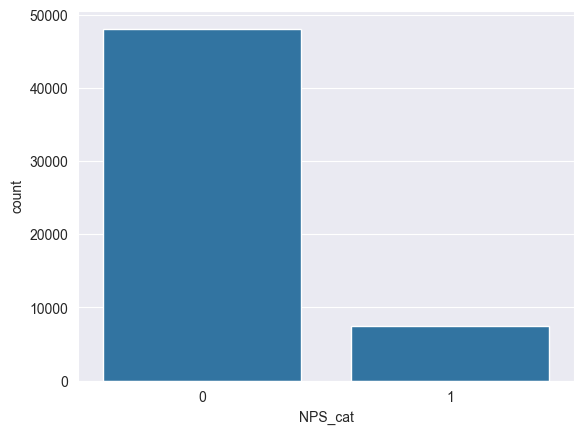

In [38]:
df_orig['NPS_cat'].value_counts(sort=True)
sns.countplot(df_orig, x = 'NPS_cat')

# Data sampling
It is possible to balance the classes via downsampling the majority class (satisfied users). This can create two classes with the size of 8.6K samples each. This can simplify the model training. However, when the class ratio in reality is 8 to 1. The model which was trained with balanced dataset may have high recall (finding satisfied users) while also having high rate of false positives. This can lead to a model with low precision in real world situations.

On the other hand, I assumed the business priority is having high recall without sacreficing precision (avoiding many false positives).
Low precision means wasting vouchers or customer service efforts on many false positives (already satisfied users). Therefore, I decided to leave the classes in the unbalanced state while focusing on measures to ensure the modeling is not biased towards satisfied users (the majority class).

Size of original data 55637
Size of balanced sampled data 55637


<Axes: xlabel='NPSChoiceScore', ylabel='count'>

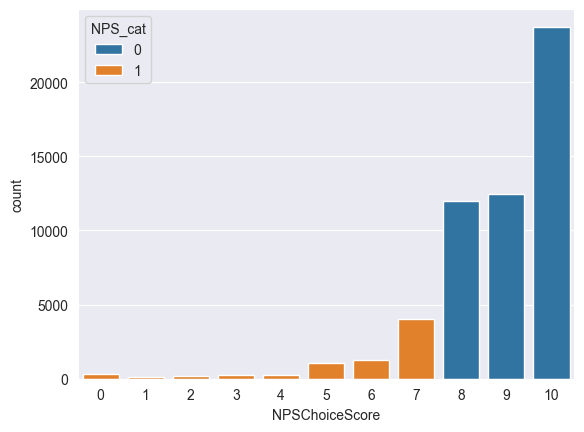

In [39]:
# It is still possible to balance the classes by downsampling the majority class

print('Size of original data', len(df_orig))
if balanced == True:
  df_satisfied = df_orig[df_orig['NPS_cat']==0]
  df_dissatisfied = df_orig[df_orig['NPS_cat']==1]
  print('Class rations:',len(df_dissatisfied)/len(df_satisfied))
  df_satisfied_sampled = df_satisfied.sample(n=len(df_dissatisfied), random_state=random_state)
  print('Balanced class rations:', len(df_dissatisfied)/len(df_satisfied_sampled))
  df_sampled = pd.concat([df_dissatisfied, df_satisfied_sampled])
  df_sampled = df_sampled.sample(frac=1, random_state=random_state).reset_index(drop=True)
else:
  df_sampled = df_orig.sample(frac=1).reset_index(drop=True)

print('Size of balanced sampled data', len(df_sampled))
df_sampled_orig = df_sampled.copy()

sns.countplot(df_sampled, x = 'NPSChoiceScore', hue = 'NPS_cat')

# Time-based Analysis
- Looking for any possible trend in user satisfaction/dissatisfaction over time.
- Time-based analysis showed missing survey data for certain months, and inconsistent survey sizes across months.
- No clear upward or downward trend in satisfaction was observed, although average satisfaction scores in 2020 were higher than in previous years.


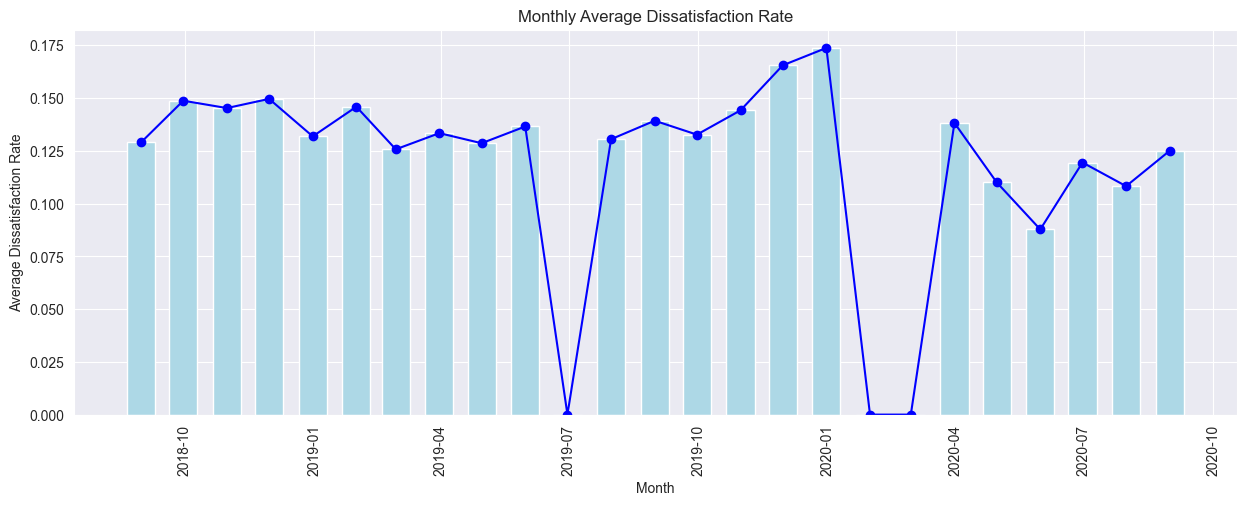

<Figure size 640x480 with 0 Axes>

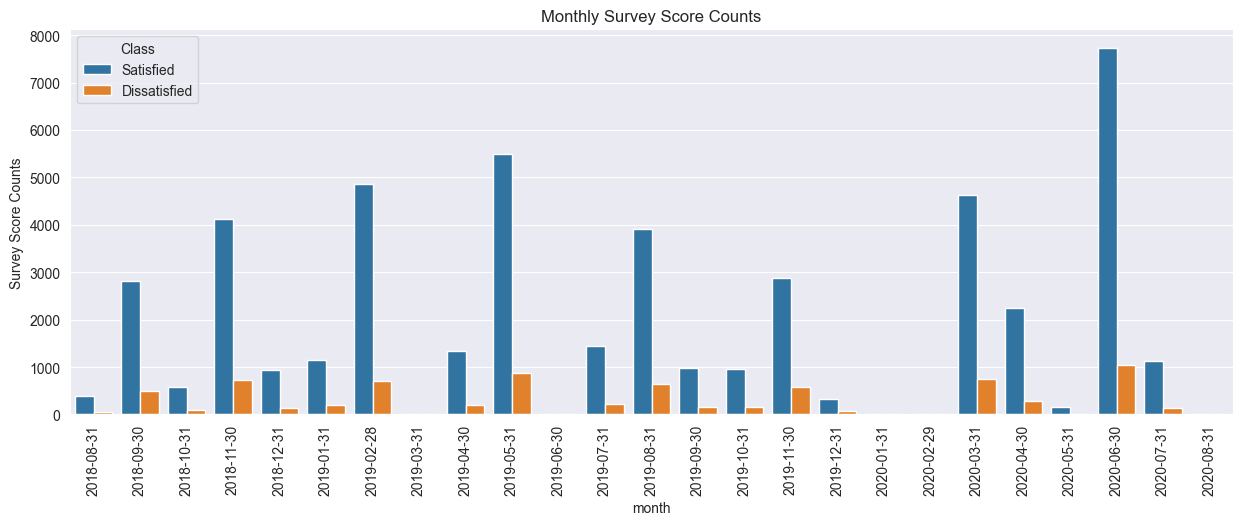

In [40]:
columns_trend = ['NPS_cat','ResponseCreationDate']
df_trends = df_orig[columns_trend] # based on original data
df_trends['ResponseCreationDate'] = pd.to_datetime(df_trends['ResponseCreationDate'])
df_trends.set_index('ResponseCreationDate', inplace=True)

# Calculate monthly average dissatisfaction rate
count_scores = df_trends.resample('ME')['NPS_cat'].count()
monthly_trends = df_trends.resample('ME')['NPS_cat'].mean().fillna(0)
monthly_trends.index = pd.to_datetime(monthly_trends.index, errors='coerce')
monthly_trends.index = monthly_trends.index.tz_localize(None)


fig = plt.figure(figsize=(15, 5))
plt.bar(monthly_trends.index, monthly_trends.values, color='lightblue', label='Dissatisfaction Rate', width=20)
plt.plot(monthly_trends.index, monthly_trends.values, color='blue', marker='o', label='Trend Line')
plt.title('Monthly Average Dissatisfaction Rate')
plt.ylabel('Average Dissatisfaction Rate')
plt.xlabel('Month')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.show()

negative_class_counts = df_trends[df_trends['NPS_cat']==0].resample('ME')['NPS_cat'].count()
positive_class_counts = df_trends[df_trends['NPS_cat']==1].resample('ME')['NPS_cat'].count()

df_counts = pd.DataFrame({
    'month': positive_class_counts.index,  # Assuming index is the same for both
    'Dissatisfied': positive_class_counts,
    'Satisfied': negative_class_counts
})
df_melted = df_counts.melt(id_vars='month', value_vars=['Satisfied', 'Dissatisfied'],
                           var_name='Class', value_name='Count')


plt.clf()
fig = plt.figure(figsize=(15, 5))
sns.barplot(x='month', y='Count', hue='Class', data=df_melted)
plt.title('Monthly Survey Score Counts')
plt.ylabel('Survey Score Counts')

t= plt.xticks(rotation=90)  
# plt.tight_layout()


# Feature engineering
The feature engineering part involves creating new features from existing ones in the following steps:
- **Temporal changes**: Relative features were created to capture any temporal drop or increase of purchases, order size, and payments in consecutive time windows.
  - Both difference and ratio-based features were created.
- **Relative values**: The ratios between number of session and orders of users were calculated. The same was applied for number of cancelations.
  

In [41]:
# diff & ratio: norders, amountinchf, norders_galaxus, norders_galaxus, norders_digitec
# norderpositions_directdelivery, norderpositions_marketplace

def norder_diff(df, feat1, feat2, div, pre = 'norders_'):
    orders_col1 = f'{pre}_last_{feat1}'
    orders_col2 = f'{pre}_last_{feat2}'
    # col_data = (df[orders_col1]/df[orders_col2]).fillna(0)
    col_data = df[orders_col1]-df[orders_col2]/div
    return col_data

def norder_ratio(df, feat1, feat2, pre='norders_'):
    orders_col1 = f'{pre}_last_{feat1}'
    orders_col2 = f'{pre}_last_{feat2}'
    # ratio_col = f'norder_ratio_{feat1}'
    col_data = (df[orders_col1]/ (df[orders_col2]+1e-4))
    return col_data

time_periods = [('month', '6m', 6),
                ('6m', 'year', 2),
                ('year', '2y', 2)]

columns = ['norders_', 'norders_galaxus_', 'norders_digitec_', 'norderpositions_directdelivery_', 'norderpositions_marketplace_']
for col in columns:
  for feat1, feat2, div in time_periods:
      df_sampled[f'{col}_ratio_{feat1}'] = norder_ratio(df_sampled, feat1, feat2, pre = col)
      df_sampled[f'{col}_diff_{feat1}'] = norder_diff(df_sampled, feat1, feat2, div, pre = col)


# month6 is not available for amountinchf
time_periods = [('monthsum', 'year_sum', 12),
                ('year_sum', '2y_sum', 2)]
for feat1, feat2, div in time_periods:
    df_sampled[f'amount_ratio_{feat1}'] = norder_ratio(df_sampled, feat1, feat2, pre = 'amountinchf')
    df_sampled[f'amount_diff_{feat1}'] = norder_diff(df_sampled, feat1, feat2, div, pre = 'amountinchf')

# canceled: ratio to orders
for time_window in ['month', '6m', 'year', '2y']:
  df_sampled[f'cancelled_diff_{time_window}'] = \
      df_sampled[f'ncancelled_orderpositions__last_{time_window}'] - df_sampled[f'norders__last_{time_window}']
  df_sampled[f'cancelled_ratio_{time_window}'] = \
      df_sampled[f'ncancelled_orderpositions__last_{time_window}'] / (df_sampled[f'norders__last_{time_window}']+1e-4)

def session_ratio(row, time_window):
    sessions_col = f'nsessions__{time_window}'
    orders_col = f'norders__{time_window}'

    if row[sessions_col] > row[orders_col]:
        if row[orders_col] > 0:
            return row[sessions_col] / row[orders_col]
        else:
            return 2 * row[sessions_col]
    else:
        return 0

# nsessions: ratio to norders
df_sampled['session_ratio_1m'] = df_sampled.apply(session_ratio, axis=1, time_window='last_month')
df_sampled['session_ratio_6m'] = df_sampled.apply(session_ratio, axis=1, time_window='last_6m')

diff_cols = [col for col in df_sampled.columns
             if ('diff_' in col.lower())
             | ('ratio_' in col.lower())]

print('Missing values in the created columns:\n', df_sampled[diff_cols].isna().sum().sum())
# df_sampled[diff_cols].info()
print('List of newly created columns:\n', diff_cols)



Missing values in the created columns:
 0
List of newly created columns:
 ['norders__ratio_month', 'norders__diff_month', 'norders__ratio_6m', 'norders__diff_6m', 'norders__ratio_year', 'norders__diff_year', 'norders_galaxus__ratio_month', 'norders_galaxus__diff_month', 'norders_galaxus__ratio_6m', 'norders_galaxus__diff_6m', 'norders_galaxus__ratio_year', 'norders_galaxus__diff_year', 'norders_digitec__ratio_month', 'norders_digitec__diff_month', 'norders_digitec__ratio_6m', 'norders_digitec__diff_6m', 'norders_digitec__ratio_year', 'norders_digitec__diff_year', 'norderpositions_directdelivery__ratio_month', 'norderpositions_directdelivery__diff_month', 'norderpositions_directdelivery__ratio_6m', 'norderpositions_directdelivery__diff_6m', 'norderpositions_directdelivery__ratio_year', 'norderpositions_directdelivery__diff_year', 'norderpositions_marketplace__ratio_month', 'norderpositions_marketplace__diff_month', 'norderpositions_marketplace__ratio_6m', 'norderpositions_marketplace__d

In [42]:
df_sampled[diff_cols].describe()

,norders__ratio_month,norders__diff_month,norders__ratio_6m,norders__diff_6m,norders__ratio_year,norders__diff_year,norders_galaxus__ratio_month,norders_galaxus__diff_month,norders_galaxus__ratio_6m,norders_galaxus__diff_6m,...,cancelled_diff_month,cancelled_ratio_month,cancelled_diff_6m,cancelled_ratio_6m,cancelled_diff_year,cancelled_ratio_year,cancelled_diff_2y,cancelled_ratio_2y,session_ratio_1m,session_ratio_6m
count,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,...,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000,55637.000000
mean,0.267478,0.197812,0.673811,0.663713,0.667666,1.088251,0.173861,0.106707,0.495364,0.360722,...,-0.822079,180.666966,-3.883315,60.635844,-6.543020,19.836792,-11.057192,0.065823,10.550412,3.277629
std,0.329171,0.937011,0.259746,1.677990,0.233530,2.693516,0.315060,0.654401,0.405213,1.145397,...,1.122276,1567.403666,4.215863,967.658053,7.441207,545.870409,12.933748,0.177464,30.925340,9.523731
min,0.000000,-23.333333,0.000000,-15.500000,0.000000,-67.000000,0.000000,-23.166667,0.000000,-17.500000,...,-26.000000,0.000000,-177.000000,0.000000,-335.000000,0.000000,-407.000000,0.000000,0.000000,0.000000
25%,0.000000,-0.333333,0.499975,0.000000,0.499988,0.000000,0.000000,-0.166667,0.000000,0.000000,...,-1.000000,0.000000,-5.000000,0.000000,-9.000000,0.000000,-15.000000,0.000000,0.000000,0.000000
50%,0.166664,0.000000,0.666644,0.500000,0.647055,1.000000,0.000000,0.000000,0.499988,0.000000,...,-1.000000,0.000000,-3.000000,0.000000,-4.000000,0.000000,-7.000000,0.000000,2.000000,0.000000
75%,0.499975,0.666667,0.999900,1.500000,0.866661,2.000000,0.249994,0.333333,0.999900,0.500000,...,0.000000,0.000000,-1.000000,0.000000,-2.000000,0.026316,-3.000000,0.071428,8.000000,3.166667
max,0.999996,19.166667,0.999997,37.000000,0.999999,203.000000,0.999996,19.166667,0.999998,30.500000,...,10.000000,100000.000000,113.000000,90000.000000,309.000000,60000.000000,623.000000,8.886065,1306.000000,547.000000


# Feature preprocessing
Here, we handle outlier removal, dealing with skewness, and performing normalization of features.

The current features suffer from outliers, skewness, and extreme differences in variance. We follow these strategies for feature preprocessing:
- Outliers are removed using IQR method if the number of outliers is less than 5% of the total observations.
- Skewness is corrected using log transform (one can also try the Box-Cox transformation).
- All features are normalized between 0 and 1. Although this may not affect the XGBoost performance, it can help feature extraction and 2D embedding parts.

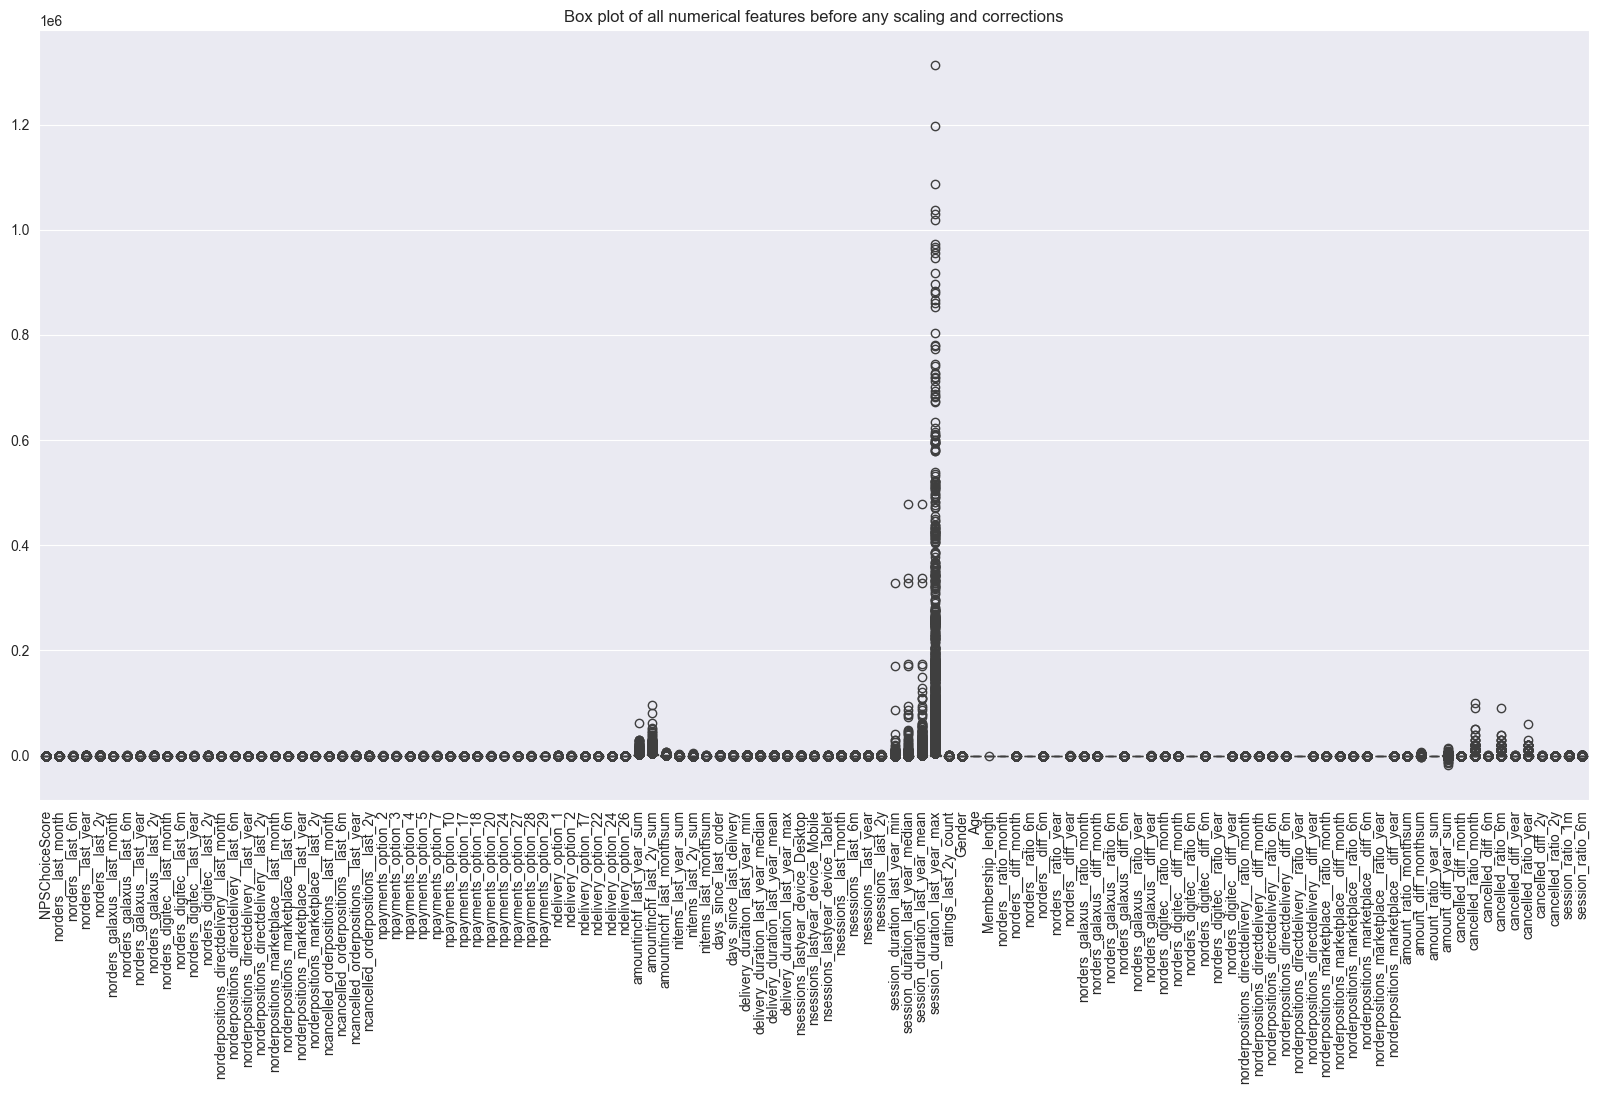

In [43]:
# Box plot visualization of all numerical features before any scaling and corrections
num_cols_all = df_sampled.select_dtypes('number').columns
num_cols_all = num_cols_all.drop(['NPS_cat','CantonId'])

df_box = df_sampled[num_cols_all]
plt.figure(figsize=(20, 10))
sns.boxplot(data=df_box)
plt.title('Box plot of all numerical features before any scaling and corrections')
t = plt.xticks(rotation=90)

A sample of outliers in the data:

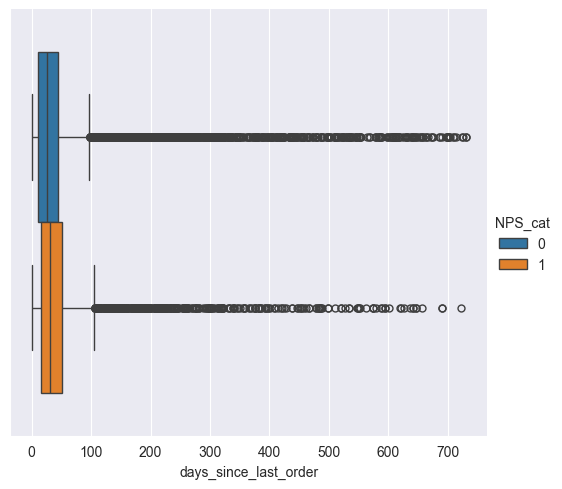

In [44]:
sns.catplot(df_sampled, x = 'days_since_last_order', kind = 'box', hue = 'NPS_cat')

A sample of skewness correction is shown below:

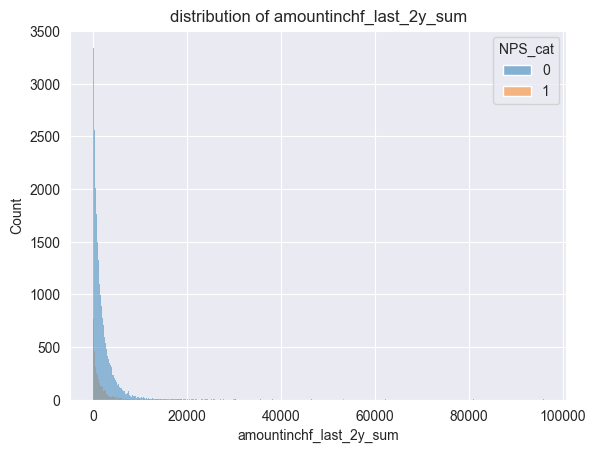

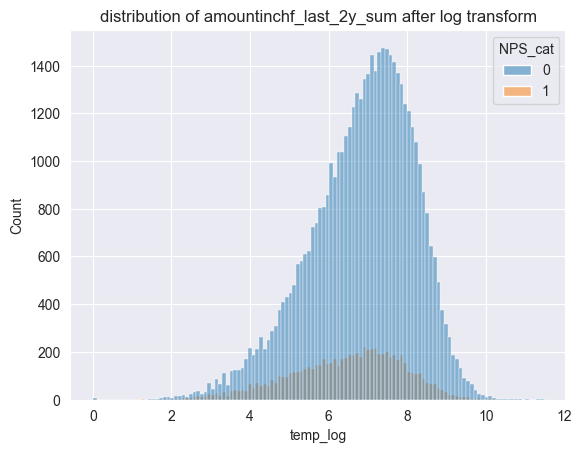

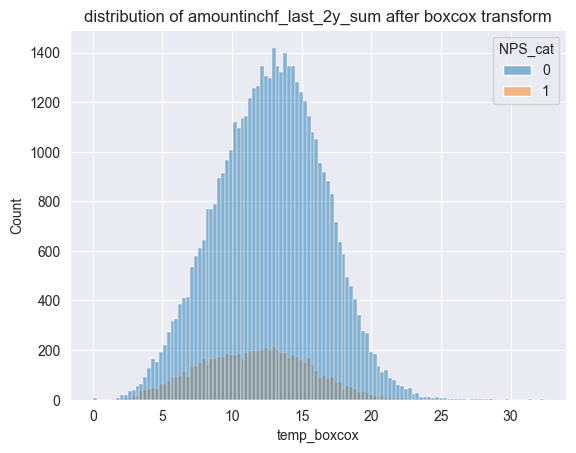

In [45]:
feature = 'amountinchf_last_2y_sum'
sns.histplot(df_sampled, x = feature, hue = 'NPS_cat')
plt.title(f'distribution of {feature}')
plt.show()
plt.clf()
df_sampled['temp_log'] = np.log1p(df_sampled[feature])  # log transform with log(1+x)
df_sampled['temp_boxcox'], _ = stats.boxcox(df_sampled[feature] + +abs(min(df_sampled[feature])) + 1)  # log transform with log(1+x)
sns.histplot(df_sampled, x = 'temp_log', hue = 'NPS_cat')
plt.title(f'distribution of {feature} after log transform')
plt.show()
plt.clf()

sns.histplot(df_sampled, x = 'temp_boxcox', hue = 'NPS_cat')
plt.title(f'distribution of {feature} after boxcox transform')
df_sampled.drop(columns = ['temp_log'], inplace=True)
df_sampled.drop(columns = ['temp_boxcox'], inplace=True)


Outlier removal and skewness correction are applied to all numerical features in the dataset.

In [46]:
import numbers
df_sampled_fcorrect = df_sampled.copy()

def outlier_analysis(df, feature, threshold=1.5, remove = False):
  # print(remove)
  print('\ncolumn:', feature)
  IQR = iqr(df[feature])
  low_bound = df[feature].mean() - 1.5*IQR
  high_bound = df[feature].mean() + 1.5*IQR
  index_outliers = (df[feature] < low_bound) | (df[feature] > high_bound)
  df_out = df[index_outliers]
  out_ratio = len(df_out)/len(df)
  print('Ratio of outliers:', out_ratio)
  if out_ratio == 0:
    print('No removal')
    return df
  if remove == True:
    df = df[~index_outliers]
    print('Outliers removed')
  elif isinstance(remove, numbers.Number):
    if out_ratio < remove:
      df = df[~index_outliers]
      print('Outliers removed')
    elif out_ratio < 0.5:
      df[feature] = np.log1p(df[feature]+abs(min(df[feature])))  # log transform with log(1+x)
      print('Feature log transformed')
  return df

if outlier_remove == True:
  for col in num_cols_all:
    df_sampled_fcorrect = outlier_analysis(df_sampled_fcorrect, col, remove = 0.05)

print('Ratio of total removed outlier samples:\n', 1-(len(df_sampled_fcorrect)/len(df_sampled)))
print('\nClass label ratio after outlier removal:\n', df_sampled_fcorrect['NPS_cat'].value_counts())


column: NPSChoiceScore
Ratio of outliers: 0.03984758344267304
Outliers removed

column: norders__last_month
Ratio of outliers: 0.07459752901535005
Feature log transformed

column: norders__last_6m
Ratio of outliers: 0.07248221639835267
Feature log transformed

column: norders__last_year
Ratio of outliers: 0.07648820666417072
Feature log transformed

column: norders__last_2y
Ratio of outliers: 0.07504679895170348
Feature log transformed

column: norders_galaxus__last_month
Ratio of outliers: 0.08487457880943466
Feature log transformed

column: norders_galaxus__last_6m
Ratio of outliers: 0.06362785473605391
Feature log transformed

column: norders_galaxus__last_year
Ratio of outliers: 0.07841632347435418
Feature log transformed

column: norders_galaxus__last_2y
Ratio of outliers: 0.08603519281168102
Feature log transformed

column: norders_digitec__last_month
Ratio of outliers: 0.08167353051291651
Feature log transformed

column: norders_digitec__last_6m
Ratio of outliers: 0.06637963309

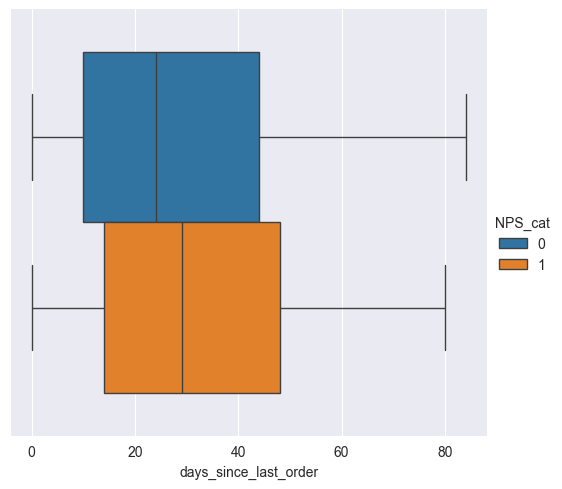

In [47]:
sns.catplot(df_sampled_fcorrect, x = 'days_since_last_order', kind = 'box', hue = 'NPS_cat')

Balancing the classes again, if aimed for class balance training:

In [48]:
# Balancing classes
if balanced == True:
    print(df_sampled_fcorrect['NPS_cat'].value_counts())
    n = df_sampled_fcorrect['NPS_cat'].value_counts().min()
    df_classA = df_sampled_fcorrect[df_sampled_fcorrect['NPS_cat']==0].sample(n=n, random_state=42)
    df_classB = df_sampled_fcorrect[df_sampled_fcorrect['NPS_cat']==1].sample(n=n, random_state=42)
    df_sampled_fcorrect = pd.concat([df_classA, df_classB])
    df_sampled_fcorrect = df_sampled_fcorrect.sample(frac=1, random_state=42)
    df_sampled_fcorrect['NPS_cat'].value_counts()

Performing a min-max normalization of all numerical features to scale them between 0 and 1.:

In [49]:
# normalize min max
scaler = MinMaxScaler()
df_features = df_sampled_fcorrect.select_dtypes('number').drop(columns = ['NPS_cat'])
scaler.fit(df_features)
df_normalized = scaler.transform(df_features)
df_normalized = pd.DataFrame(df_normalized, columns=df_features.columns)
df_normalized.describe()

,NPSChoiceScore,norders__last_month,norders__last_6m,norders__last_year,norders__last_2y,norders_galaxus__last_month,norders_galaxus__last_6m,norders_galaxus__last_year,norders_galaxus__last_2y,norders_digitec__last_month,...,cancelled_diff_month,cancelled_ratio_month,cancelled_diff_6m,cancelled_ratio_6m,cancelled_diff_year,cancelled_ratio_year,cancelled_diff_2y,cancelled_ratio_2y,session_ratio_1m,session_ratio_6m
count,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,...,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000,51358.000000
mean,0.750526,0.163847,0.153737,0.199578,0.228819,0.085166,0.148026,0.172316,0.208915,0.098206,...,0.888050,0.002104,0.910367,0.005363,0.921844,0.006069,0.900436,0.023190,0.179527,0.127335
std,0.271230,0.157269,0.127161,0.132087,0.139914,0.132519,0.128981,0.134818,0.149081,0.154279,...,0.017284,0.022609,0.006019,0.018980,0.005490,0.018491,0.006606,0.049286,0.193192,0.155753
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.500000,0.000000,0.082473,0.072142,0.127192,0.000000,0.000000,0.109819,0.105899,0.000000,...,0.886585,0.000000,0.909443,0.000000,0.920816,0.000000,0.899157,0.000000,0.000000,0.000000
50%,0.750000,0.218104,0.140989,0.195469,0.220928,0.000000,0.123648,0.174059,0.211798,0.000000,...,0.886585,0.000000,0.911471,0.000000,0.922750,0.000000,0.901814,0.000000,0.153106,0.000000
75%,1.000000,0.218104,0.223462,0.286356,0.328787,0.218104,0.247296,0.254991,0.317698,0.255958,...,0.900132,0.000000,0.913477,0.000000,0.924184,0.000000,0.903312,0.029688,0.306212,0.227565
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Boxplots of the normalized data:

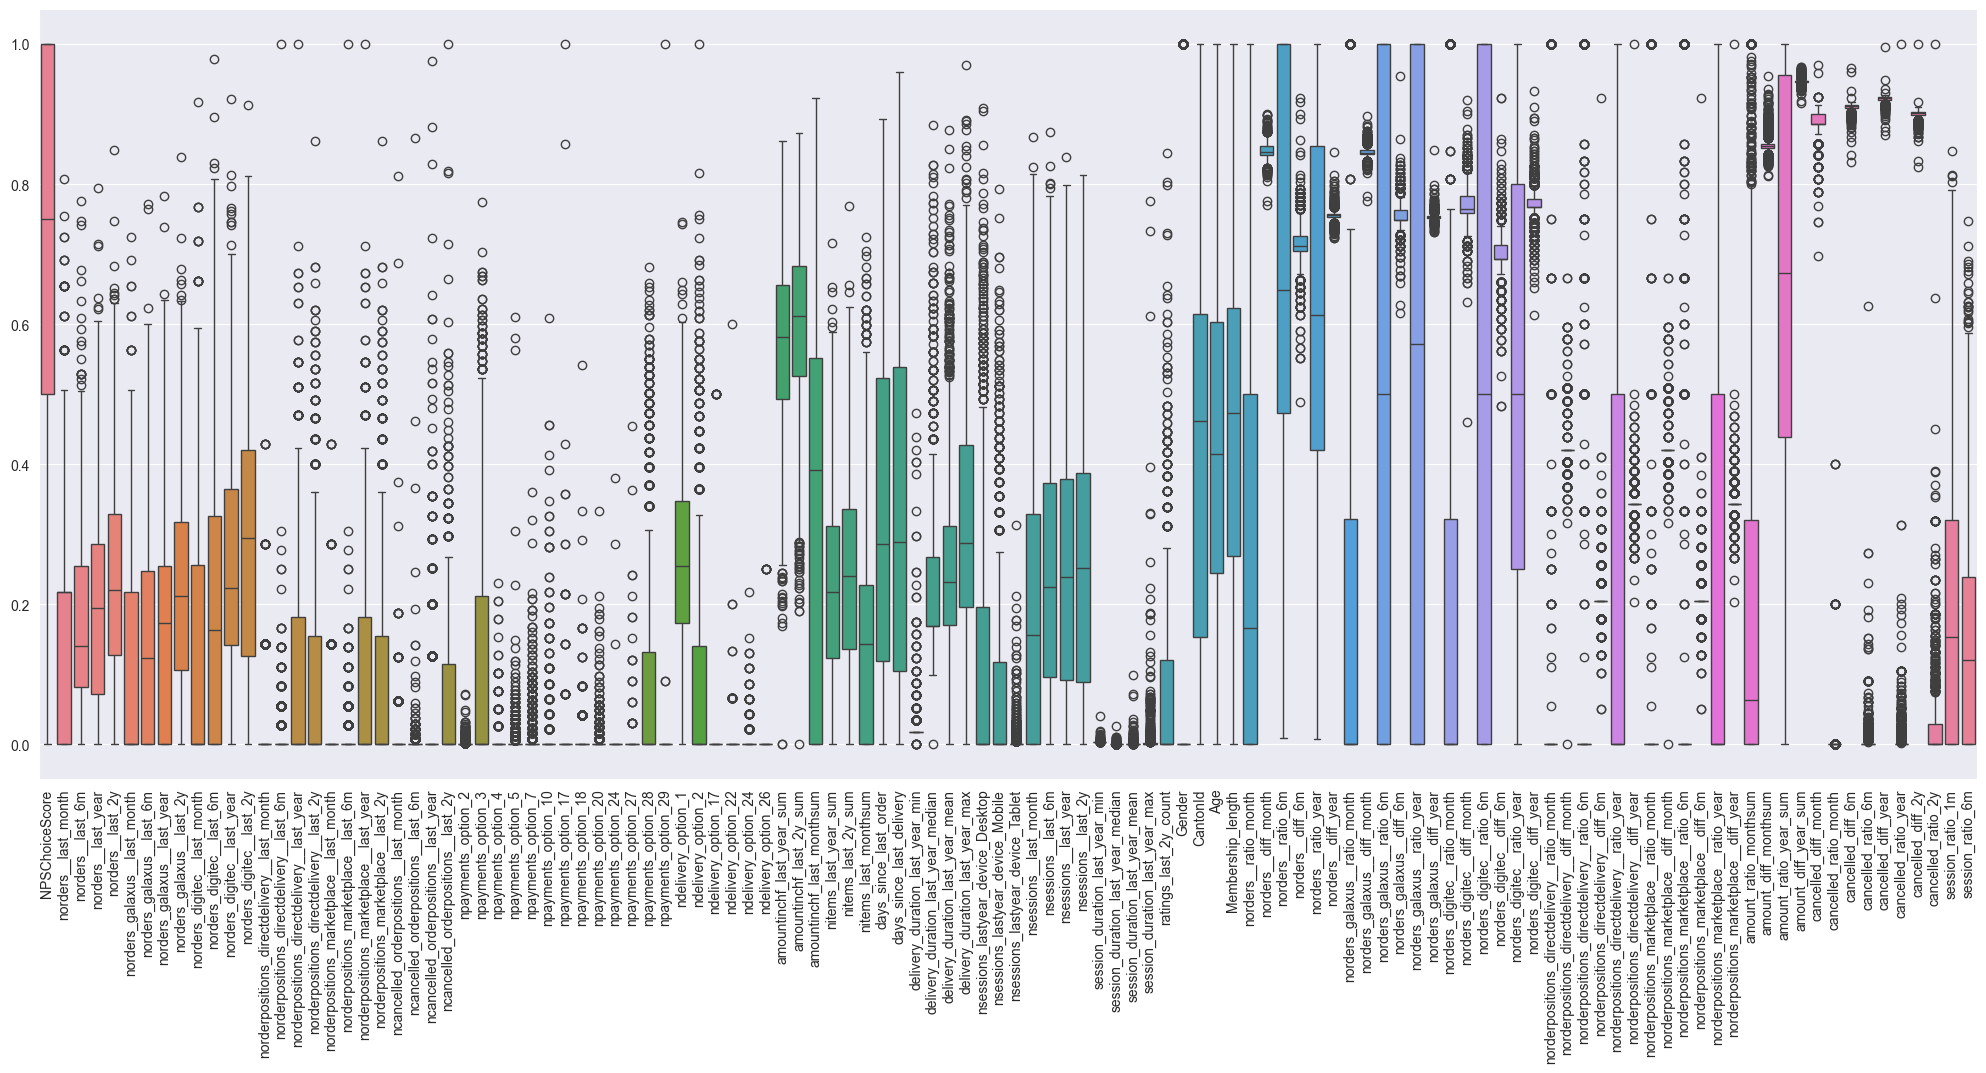

In [50]:
df_normalized_small = df_normalized.sample(frac=0.051, random_state=random_state)
plt.figure(figsize=(25, 10))
sns.boxplot(data=df_normalized_small)
plt.xticks(rotation=90)
plt.show()

# Feature Selection
Here, we incorporate linear correlation analysis and mutual information to remove redundant features as well as irrelevant features for the binary classification task.

## Correlation analysis
- Finding features that are highly correlated linearly
- However when using xgboost and tree based methods, we can continue with all features and let the model explore possible nonlinear relationship or feature interaction between highly correlated featuers.
- For linear models, we should remove these highly correlated feateures first. For example absolute features vs. delta difference feateurs.

High linear correlations among feature pairs:

norderpositions_directdelivery__ratio_month and norderpositions_marketplace__ratio_month: correlation = 1.00
delivery_duration_last_year_median and delivery_duration_last_year_min: correlation = 1.00
delivery_duration_last_year_mean and delivery_duration_last_year_median: correlation = 1.00
delivery_duration_last_year_min and delivery_duration_last_year_mean: correlation = 1.00
days_since_last_delivery and days_since_last_order: correlation = 0.99
nsessions__last_year and nsessions__last_6m: correlation = 0.98
nsessions__last_year and nsessions__last_2y: correlation = 0.98
delivery_duration_last_year_max and delivery_duration_last_year_mean: correlation = 0.96
ncancelled_orderpositions__last_2y and ncancelled_orderpositions__last_year: correlation = 0.96
nsessions__last_6m and nsessions__last_month: correlation = 0.96
cancelled_diff_month and norders__last_month: correlation = -0.95
delivery_duration_last_year_max and delivery_duration_las

['norderpositions_marketplace__ratio_month',
 'delivery_duration_last_year_median',
 'norders__last_month',
 'cancelled_diff_6m',
 'nsessions__last_year',
 'nsessions__last_2y',
 'delivery_duration_last_year_mean',
 'norders_digitec__last_year',
 'norders_galaxus__last_2y',
 'cancelled_diff_2y',
 'days_since_last_order',
 'nsessions__last_6m',
 'amount_diff_monthsum',
 'norders_galaxus__last_year',
 'ncancelled_orderpositions__last_year',
 'norders__last_year',
 'delivery_duration_last_year_min',
 'nitems_last_2y_sum']

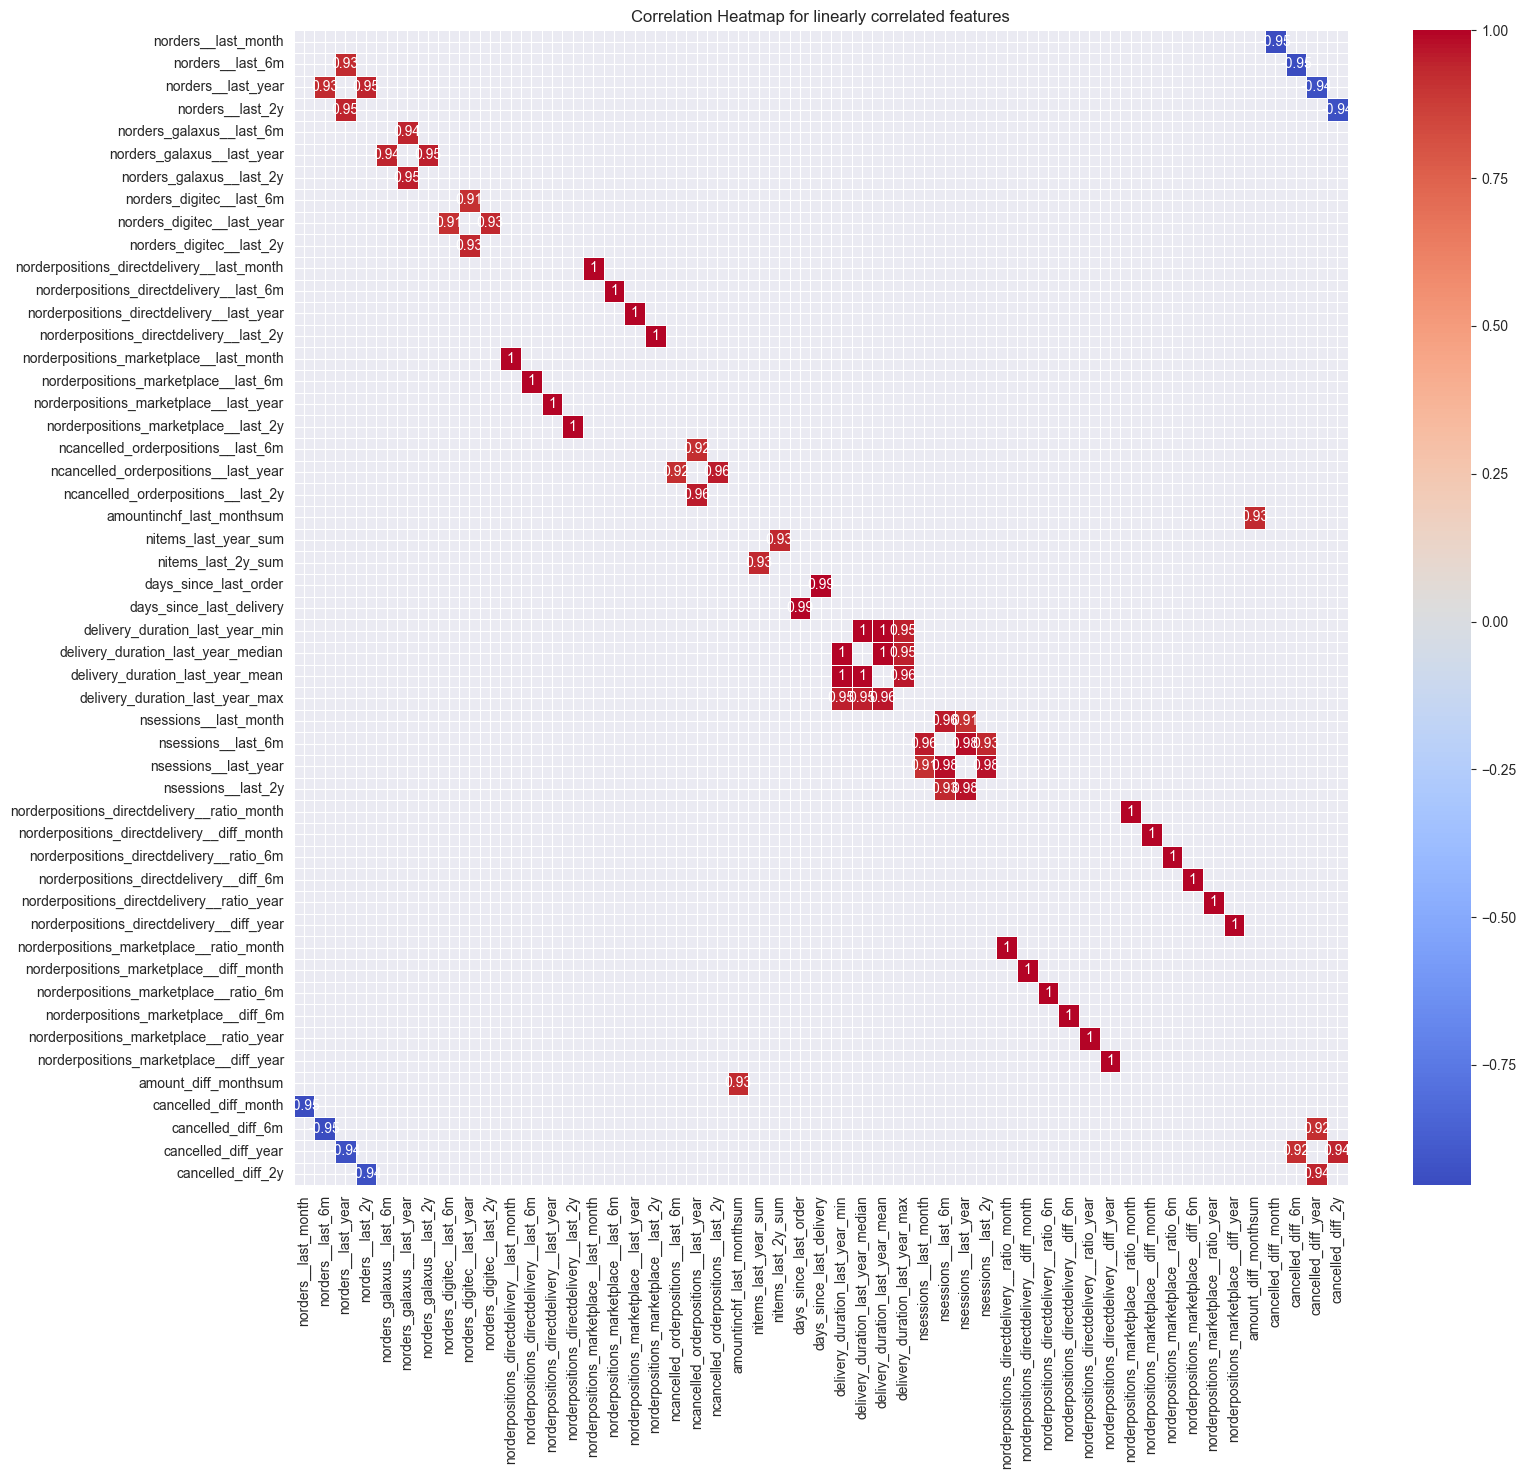

In [51]:
num_cols_all = df_sampled.select_dtypes('number').columns
cor_matrix = df_sampled[num_cols_all].corr()
cor_matrix['NPS_cat'].sort_values(ascending=False)
# fig = plt.figure(figsize=(20, 17))

# find all entries inside dataframe cor_matrix with value higher than 0.7
df_high_corr = cor_matrix[cor_matrix.abs() > lincorelation_thresh]
# df_mask = df_high_corr.copy()
np.fill_diagonal(df_high_corr.values, np.nan)
df_high_corr = df_high_corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

df_high_corr_unstacked = df_high_corr.unstack()
df_high_corr_unstacked = df_high_corr_unstacked.dropna()
# df_high_corr_sorted = df_high_corr_unstacked.sort_values( ascending=False)
df_high_corr_sorted = df_high_corr_unstacked.reindex(df_high_corr_unstacked.abs().sort_values(ascending=False).index)
df_high_corr_unique = pd.DataFrame(df_high_corr_sorted)
df_high_corr_unique.drop_duplicates(inplace=True)

drop_linCor_features = set()
print('High linear correlations among feature pairs:\n')
for (feature1, feature2), corr_value in df_high_corr_unique.iterrows():
  print(f"{feature1} and {feature2}: correlation = {corr_value.values[0]:.2f}")
  if feature1 not in drop_linCor_features and feature2 not in drop_linCor_features:
    drop_linCor_features.add(feature2)
drop_linCor_features = list(drop_linCor_features)

fig = plt.figure(figsize=(17, 15))
sns.heatmap(df_high_corr, annot = True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for linearly correlated features')
print('\nFeatures to drop due to their hight linear correlations:\n')
drop_linCor_features

# 2D Visualization of Data Distributions

We use **t-SNE** to reduce the dimensionality of the data to 2 dimensions for visualization purposes and to inspect potential patterns in the data. t-SNE is well-suited for visualizing smaller datasets and is effective at preserving local clusters of similar data points.

For larger datasets, **UMAP** can also be a suitable alternative, as it is faster, scales better with large data, and tends to preserve both local and global structure more effectively.

The 2D visualization shows distinct clusters of data distributions, which appear to be associated with different **SurveyContext** and **Gender** groups. This suggests that certain patterns in user satisfaction may be influenced by these factors, warranting further exploration of their impact on the model’s predictions.

Length of data used for visualization 2619
Size of visualizaion data 2619


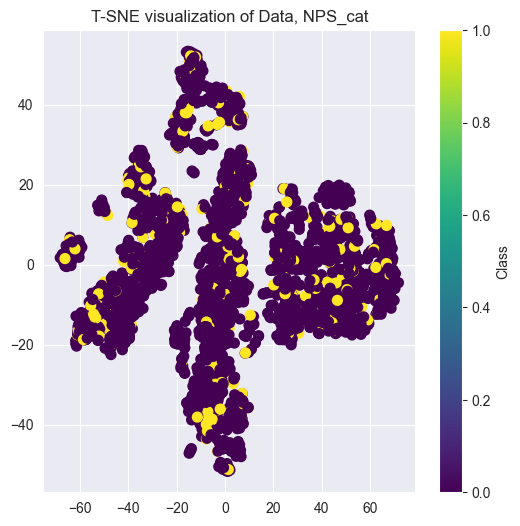

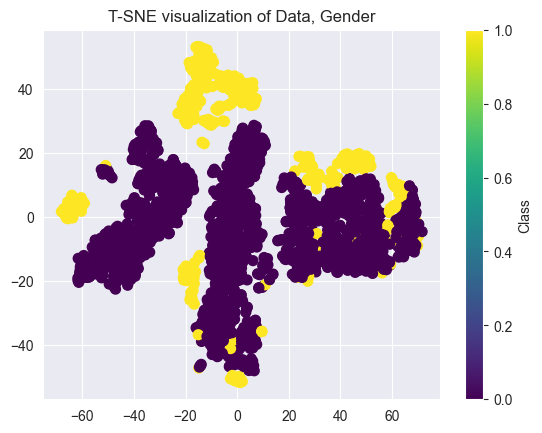

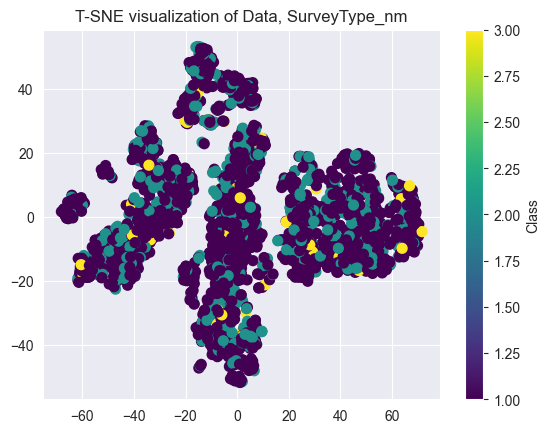

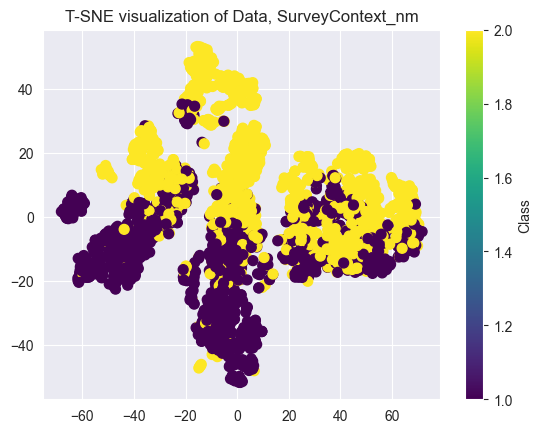

<Figure size 640x480 with 0 Axes>

In [52]:
feature_cols = df_sampled_fcorrect.select_dtypes('number').columns
feature_cols = feature_cols.drop(['NPS_cat', 'NPSChoiceScore']+drop_linCor_features)

# map values of 'SurveyType' column to integers from 1 to the last unique value of that column
df_sampled_vis = df_sampled_fcorrect.sample(frac = 0.051)
print('Length of data used for visualization',len(df_sampled_vis))

for col in ['SurveyContext', 'SurveyType']:
  map_dic = {val: i+1 for i, val in enumerate(df_sampled_vis[col].unique())}
  df_sampled_vis[f'{col}_nm'] = df_sampled_vis[col]\
      .map(map_dic)


# Apply T-SNE for 2d visualization
tsne = TSNE(n_components=2)

print('Size of visualizaion data', len(df_sampled_vis))

X_subset = df_sampled_vis[feature_cols].values
X_subset = scaler.fit_transform(X_subset)
y_subset = df_sampled_vis['NPS_cat'].values

X_tsne = tsne.fit_transform(X_subset)

plt.figure(figsize=(6, 6))
segment_cols = ['NPS_cat',
                'Gender',
                'SurveyType_nm',
                'SurveyContext_nm'
                ]
for col in segment_cols:
  y_subset = df_sampled_vis[col].values
  plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap='viridis', s=50)
  plt.colorbar(label='Class')
  plt.title(f'T-SNE visualization of Data, {col}')
  plt.show()
  plt.clf()


## Mutual information
The feature with the highest mutual information score has a relatively low value, which indicates lack of any single feature that can have a high contribution to predicting the target class label.

Features to drop due to relatively small MI score:


['npayments_option_2',
 'npayments_option_4',
 'norders_galaxus__ratio_year',
 'norderpositions_directdelivery__diff_month',
 'norderpositions_directdelivery__last_year',
 'amount_diff_year_sum',
 'norderpositions_marketplace__ratio_year',
 'norderpositions_marketplace__last_6m',
 'ndelivery_option_22',
 'session_duration_last_year_max',
 'ncancelled_orderpositions__last_month',
 'norders_galaxus__ratio_month',
 'cancelled_ratio_year',
 'ncancelled_orderpositions__last_2y',
 'Age',
 'norders__diff_year',
 'norderpositions_marketplace__diff_6m',
 'norderpositions_marketplace__diff_month',
 'nsessions_lastyear_device_Desktop',
 'norders_galaxus__last_month',
 'npayments_option_24',
 'session_ratio_1m',
 'norderpositions_marketplace__ratio_6m',
 'norderpositions_directdelivery__ratio_6m',
 'ndelivery_option_2',
 'norderpositions_directdelivery__last_6m',
 'npayments_option_3',
 'norderpositions_marketplace__last_month',
 'norderpositions_marketplace__last_year',
 'ncancelled_orderposition

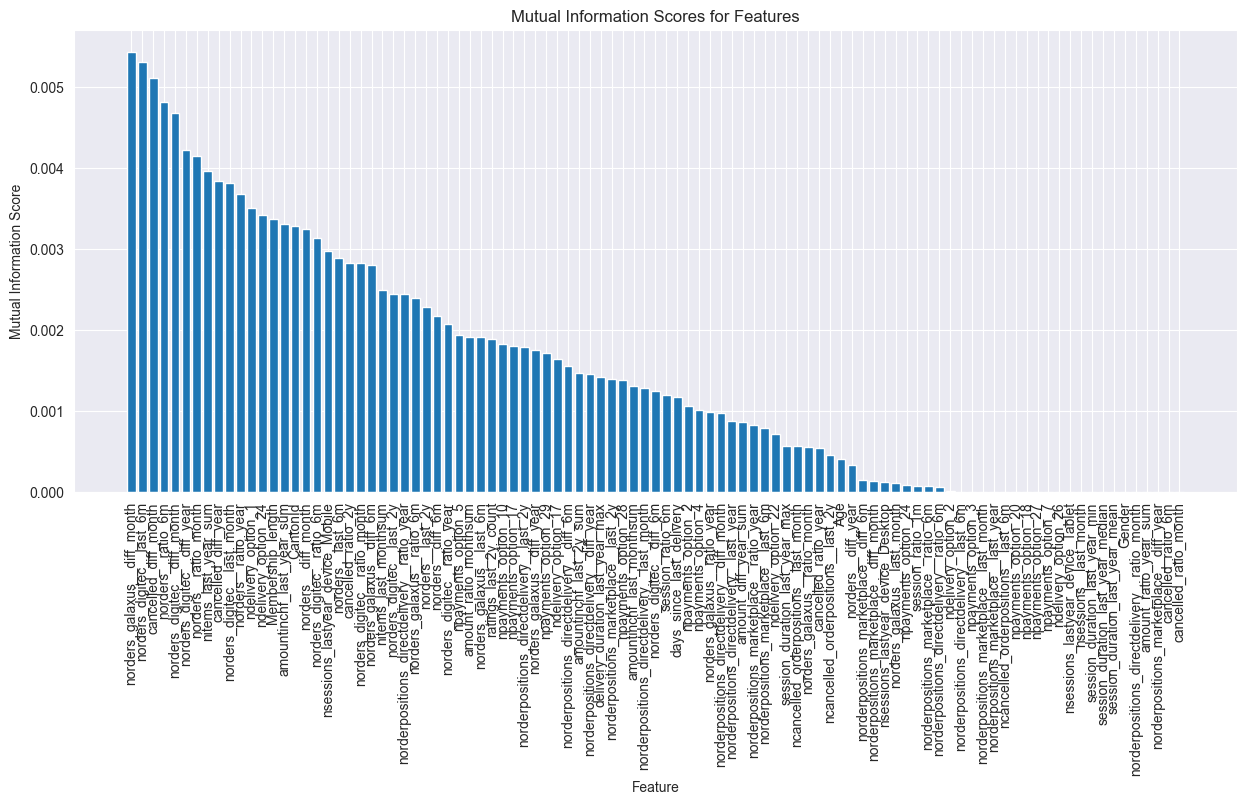

In [53]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
# pca = PCA(n_components=5)  # Adjust the number of components
# X = pca.fit_transform(X)

feature_cols = df_sampled_fcorrect.select_dtypes('number')\
    .columns.drop(['NPS_cat', 'NPSChoiceScore']+drop_linCor_features)

# print('Numerical input features:\n',feature_cols)
X = df_sampled_fcorrect[feature_cols].values

y = df_sampled_fcorrect['NPS_cat'].values
mi_scores = mutual_info_classif(X, y)

feature_ranks = pd.Series(mi_scores, index=feature_cols)
feature_ranks = feature_ranks.sort_values(ascending=False)

# drop features with less than 20% MI compared to the highest MI
threshold = 0.2*feature_ranks.max()
drop_features = feature_ranks[feature_ranks < threshold]
drop_MI_features = drop_features.index.tolist()

plt.figure(figsize=(15, 6))
plt.bar(feature_ranks.index, feature_ranks.values)
plt.xlabel('Feature')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Features')
plt.xticks(rotation=90)

print('Features to drop due to relatively small MI score:')
drop_MI_features

Removing both linearly correlated features and features with low MI scores from the feature set

In [54]:
# removing features
feature_cols = df_sampled_fcorrect.select_dtypes('number').columns.drop(['NPS_cat', 'NPSChoiceScore'])
feature_cols = feature_cols.drop(drop_MI_features+drop_linCor_features)
print('Input features after feature selection:\n')
print(feature_cols)

Input features after feature selection:

Index(['norders__last_6m', 'norders__last_2y', 'norders_galaxus__last_6m',
       'norders_digitec__last_month', 'norders_digitec__last_6m',
       'norders_digitec__last_2y',
       'norderpositions_directdelivery__last_month',
       'norderpositions_directdelivery__last_2y',
       'norderpositions_marketplace__last_2y', 'npayments_option_5',
       'npayments_option_10', 'npayments_option_17', 'npayments_option_28',
       'npayments_option_29', 'ndelivery_option_1', 'ndelivery_option_17',
       'ndelivery_option_24', 'amountinchf_last_year_sum',
       'amountinchf_last_2y_sum', 'amountinchf_last_monthsum',
       'nitems_last_year_sum', 'nitems_last_monthsum',
       'days_since_last_delivery', 'delivery_duration_last_year_max',
       'nsessions_lastyear_device_Mobile', 'ratings_last_2y_count', 'CantonId',
       'Membership_length', 'norders__ratio_month', 'norders__diff_month',
       'norders__ratio_6m', 'norders__diff_6m', 'norders__

# Classifier Training

- Among various classifiers tested (KNN, Random Forest, Kernel SVM), **XGBoost** was selected as the final classifier for this task due to its superior performance.
- The model was trained on a **stratified train-test split** to ensure that the class distribution remains balanced across both sets.
- **Class weights** were applied in the loss function to mitigate overfitting and ensure that the model does not disproportionately favor the majority class.  
- The final XGBoost parameters were determined using **GridSearchCV**, with cross-validation over the parameter space.
- The objective during training was to maximize the **F1-score** via focusing the training iterations on improving precision and recall AUC metric.
Balancing both precision and recall is essential for this task.

Data split to prepare training and test data

In [55]:
from sklearn.model_selection import train_test_split

X = df_sampled_fcorrect[feature_cols].values
y = df_sampled_fcorrect['NPS_cat'].values

X_train, X_test, y_train , y_test =\
 train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = df_sampled_fcorrect[['NPS_cat']])

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
print('Size of training and test data:',X_train.shape, y_train.shape)
print('Class imbalance ratio:',sum(y)/len(y))

Size of training and test data: (41086, 51) (41086,)
Class imbalance ratio: 0.09786206627983955


In [56]:
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

Knn_k = 15
classifier = 'xgboost'

if classifier == 'knn':
  model = KNeighborsClassifier(n_neighbors = Knn_k)
elif classifier == 'xgboost':
  scale_pos_weight = df_sampled_fcorrect['NPS_cat'].value_counts().max() / df_sampled_fcorrect['NPS_cat'].value_counts().min()
  model = XGBClassifier(
      # use_label_encoder=False,
      max_depth = 1,
      min_child_weight = 3,
      # gamma = 0.3,
      # reg_alpha = 3,
      reg_lambda = 1,      
      learning_rate = 0.8,
      # n_estimators = 5000,
      # eval_metric='logloss'
      subsample=1,
      colsample_bytree=1,
      # objective='binary:logistic',
      # eta = 0.01,
      # early_stopping_rounds=1000
      eval_metric='aucpr',
      scale_pos_weight = scale_pos_weight,
      random_state=42
      )
elif classifier == 'rf':
  model = RandomForestClassifier(n_estimators=100, random_state=42)
elif classifier == 'svm':
  model = SVC(kernel='rbf', C=1.0, gamma='scale')  # 'rbf' is the default kernel

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train);

## Evaluating the model using confusion matrix and classification report
- The confusion matrix and classification report show that the model obtained a recall score of 0.57%. Considering the high class imbalance in the data (10% positive samples), the classifier manage to reduce the natural bias toward the majority class. However, the precision score of 12% shows the model highly struggles with false positives. 
- The model inability of increasing TP predictions without leading to more FP ones comes from the high overlap of these two classes in the current features space. Specifically refering to the T-SNE visualization, each positive samples is tightly separated from the negative ones.

              precision    recall  f1-score   support

           0       0.92      0.57      0.71      9267
           1       0.13      0.57      0.21      1005

    accuracy                           0.57     10272
   macro avg       0.53      0.57      0.46     10272
weighted avg       0.85      0.57      0.66     10272


ROC-AUC Score: 0.5890526325961645


Text(0.5, 1.0, 'Confusion Matrix')

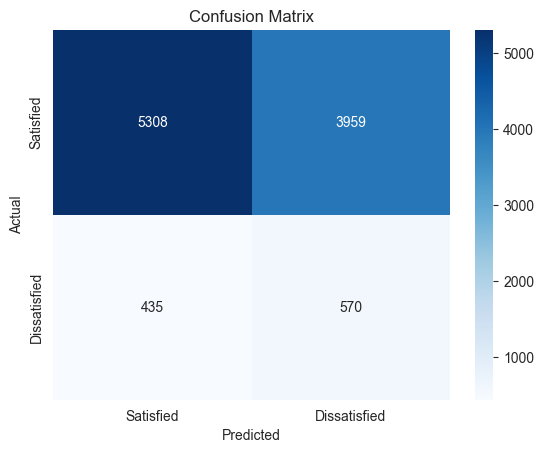

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score, precision_recall_curve 

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC-AUC
conf_matrix = confusion_matrix(y_test, y_pred)
# print('Confusion matrix for test date:\n',conf_matrix)
print(classification_report(y_test, y_pred))
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_proba)}")

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Dissatisfied'], yticklabels=['Satisfied', 'Dissatisfied'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')

## ROC-AUC curve:
The ROC-AUC curve shows that the classifier's performance is only slightly better than random guessing, which indicates room for improvement. However, given the highly imbalanced nature of the dataset, this performance still reflects the model’s ability to correctly classify a significant portion of the majority class.

In several training rounds, I found that it's possible to increase recall to around 70%, but this comes at the cost of a significant drop in precision. This trade-off makes the model less suitable for production, especially for applications like customer support or marketing, where precision is critical. High precision is essential in these departments to avoid wasting resources on false positives (i.e., incorrectly identified dissatisfied customers).

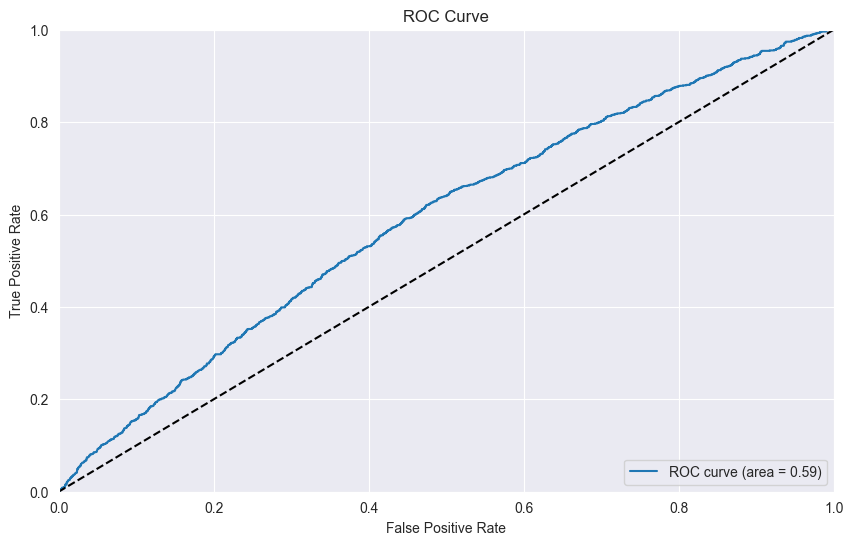

In [58]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')

# Post-Model Analysis:

## Trade-off Between Precision and Recall

- **Threshold Tuning**: Depending on the business context, we can adjust the prediction threshold to prioritize either precision or recall, but doing so will result in a trade-off.
  - **Business Questions**:
    - How critical is it to capture the majority of dissatisfied customers?
    - How many resources are available to address predicted dissatisfied users (including false positives)?
  - **Current Business Initiative**: Based on my understanding of our goals, we must balance both precision and recall to ensure:
    - **High precision**: So that the resources allocated to handling predicted dissatisfied users are not wasted.
    - **High recall**: To ensure we don’t miss many dissatisfied customers who require intervention.

- **Challenge**: At this stage, improving one metric (precision or recall) will lead to a significant sacrifice of the other metric, indicating that further refinement in the model or data may be necessary to achieve the desired balance.


C:\Users\bbkho\AppData\Local\Temp\ipykernel_44584\2175670165.py:5: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


Optimal threshold for F1 score: 0.7934030294418335
Optimal F1 score: nan


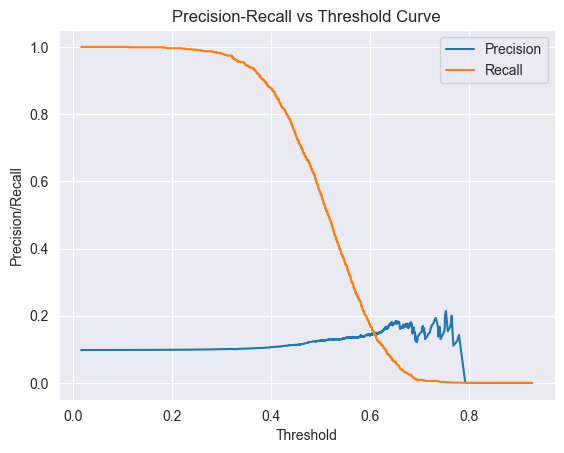

In [59]:
# Calculate Precision-Recall and Thresholds
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
y_probs = model.predict_proba(X_test)[:, 1]
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall)
max_f1_idx = np.argmax(f1_scores)
optimal_threshold = pr_thresholds[max_f1_idx]
print(f"Optimal threshold for F1 score: {optimal_threshold}")
print(f"Optimal F1 score: {f1_scores[max_f1_idx]}")

# Plot Precision-Recall Curve
plt.plot(pr_thresholds, precision[:-1], label="Precision")
plt.plot(pr_thresholds, recall[:-1], label="Recall")
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend(loc='best')
plt.title('Precision-Recall vs Threshold Curve')
plt.show()


## Working on model predictions probabilities:
- Understanding Model Confidence: When a classifier performs acceptably, its output probability values can provide valuable insights into the model’s confidence in its predictions. These probabilities represent how certain the model is about predicting a particular class, which can be used to guide decision-making.

- Actionable Insights: These probability values can be leveraged to take more informed actions based on the model’s predictions. For example, when the model is highly confident about a prediction, different business actions can be taken than when the model’s confidence is low.

- Improving Distinction Between TP and FP: In the current plot, True Positives (TP) and False Positives (FP) are not as clearly separable. With further model improvement, we expect the TP and FP clusters to become more distinct, indicating better classification performance.

- Incorporating Additional Information: Such visualizations can be combined with other relevant factors, such as a user's purchase volume or membership length, to improve decision-making. This combination of model outputs with business metrics can help create more actionable and reliable strategies.

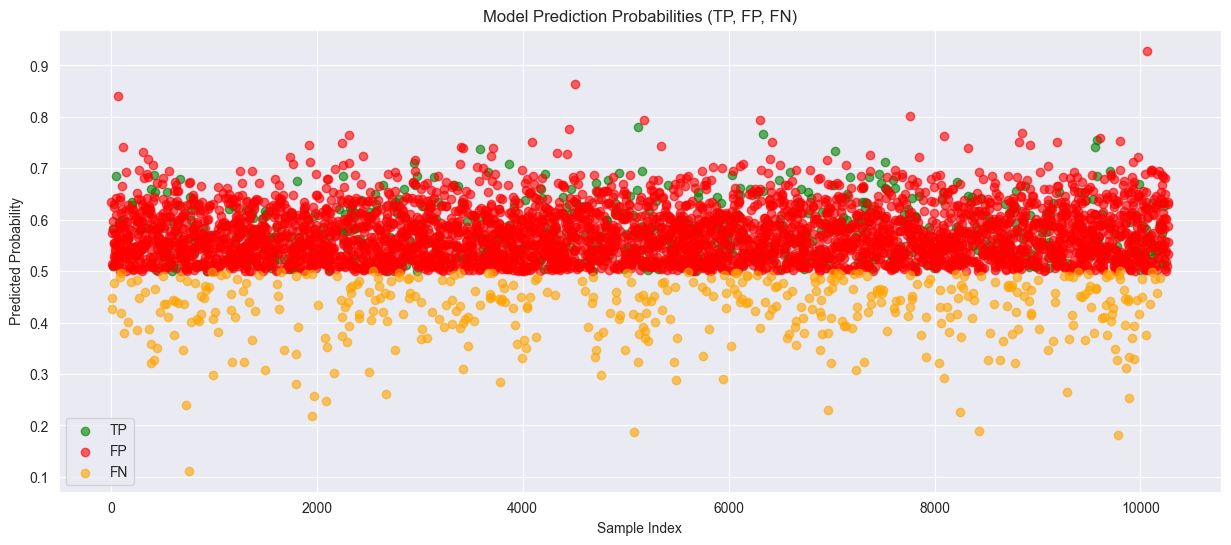

In [60]:
# Assign color to each class (TP, FP, TN, FN)
y_pred = model.predict(X_test)

# Predict probabilities for the positive class (if you want to analyze probabilities)
y_probs = model.predict_proba(X_test)[:, 1]  # Probability for class 1 (dissatisfied users)
y_true = y_test

df_results = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'y_prob': y_probs
})

# Conditions for TP, FP, TN, FN
df_results['classification'] = np.where((df_results['y_true'] == 1) & (df_results['y_pred'] == 1), 'TP',
                                  np.where((df_results['y_true'] == 0) & (df_results['y_pred'] == 1), 'FP',
                                  np.where((df_results['y_true'] == 0) & (df_results['y_pred'] == 0), 'TN',
                                  'FN')))

colors = {
    'TP': 'green',
    'FP': 'red',
    # 'TN': 'blue',
    'FN': 'orange'
}

plt.figure(figsize=(15,6))
# Plot each classification with different colors
for cls, color in colors.items():
    subset = df_results[df_results['classification'] == cls]
    plt.scatter(subset.index, subset['y_prob'], color=color, label=cls, alpha=0.6)

plt.title('Model Prediction Probabilities (TP, FP, FN)')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability')
plt.legend()


# Feature Importance and Feature Selection

## XGBoost Feature Importance
One of the key strengths of tree-based models, such as XGBoost, is their ability to identify the most important features in the dataset. These features are those that contribute the most to the model's predictions. The L1 and L2 regularization parameters in the model training influence the choice of the most important features. 

**Note:** When using other types of models, tools like **SHAP** or **ELI5** can be utilized to identify important features and interpret individual model predictions. These tools provide insights into feature importance and help explain model decisions for specific data point or class of data.

The top most important features for the xgboost model are as in the following figure. 
If we had a good classification model, we could interpret those features as important factors leading to a customer being dissatisfied or satisfied.

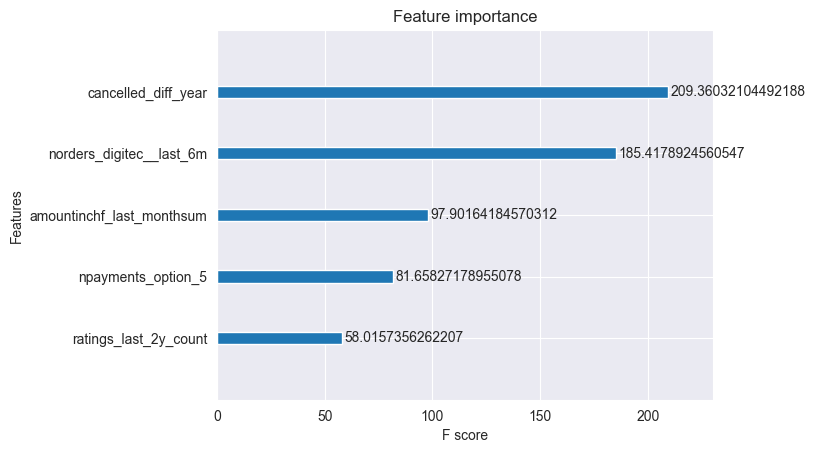

Feature: cancelled_diff_year, Importance: 0.1350555568933487
Feature: norders_digitec__last_6m, Importance: 0.11961060762405396
Feature: amountinchf_last_monthsum, Importance: 0.06315504014492035
Feature: npayments_option_5, Importance: 0.05267666280269623
Feature: ratings_last_2y_count, Importance: 0.03742517530918121


<Axes: >

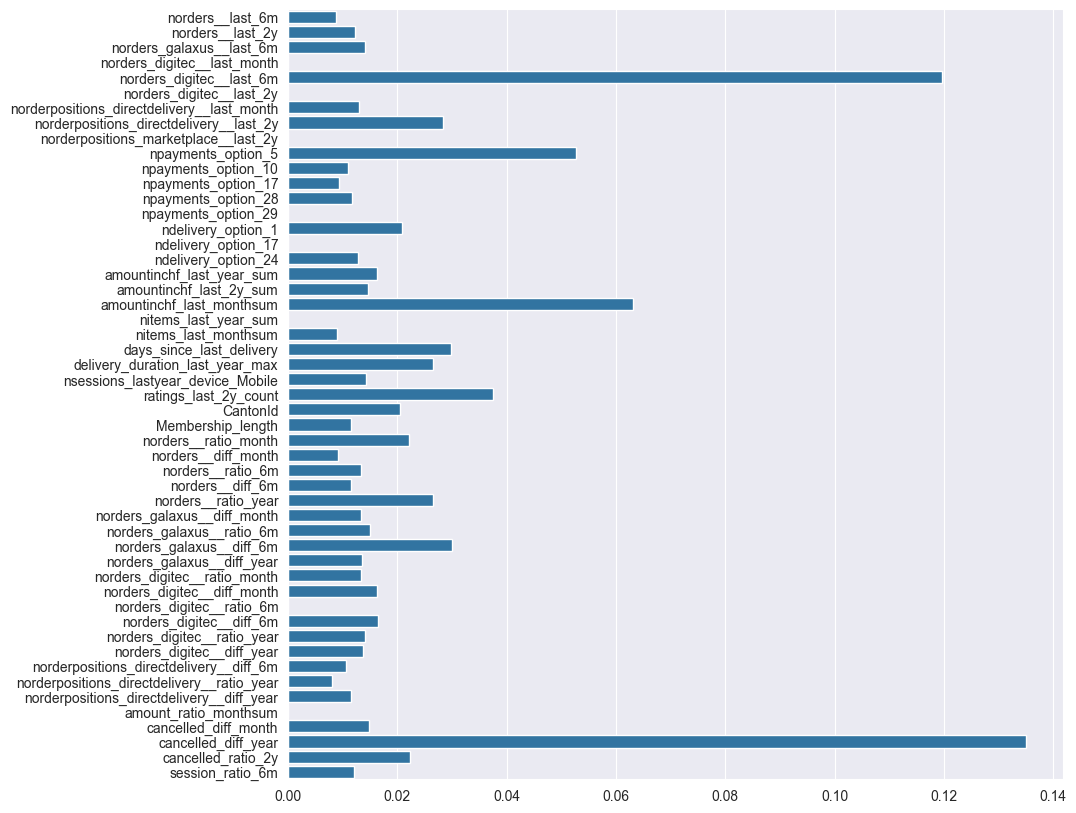

In [61]:
from xgboost import plot_importance
model.get_booster().feature_names = list(feature_cols)

plot_importance(model,importance_type='gain', max_num_features=5)
plt.show()

importance = model.feature_importances_
features = tuple(feature_cols)
sorted_features = sorted(zip(features, importance), key=lambda x: x[1], reverse=True)
top_5_features = sorted_features[:5]
for feature, importance_score in top_5_features:
    print(f"Feature: {feature}, Importance: {importance_score}")
    
plt.figure(figsize=(10, 10))
sns.barplot(x=importance, y=features)

## Feature Selection Using Recursive Feature Elimination (RFE)
Recursive Feature Elimination (RFE) is another effective technique for feature selection. RFE works by iteratively removing the least important features from the model and evaluating the model’s performance at each step, allowing it to find the optimal subset of features.

In the folllwoing we see that with about 10 features can obtain almost a close Recall and Precision performance as the original classifier achieved with about 50 features.

While there is often overlap between the features selected by RFE and those deemed important by XGBoost, RFE places a stronger emphasis on **model performance**, whereas XGBoost’s feature importance can be influenced by the model’s **regularization parameters**.

Both methods ultimately aim to improve the model’s generalization ability, reduce overfitting, lower training time, and leading to a more efficient and robust model. 

RFE selected 10 features

Selected features by RFE:
 Index(['norders__last_6m', 'norders__last_2y', 'norders_digitec__last_6m',
       'npayments_option_5', 'amountinchf_last_year_sum',
       'amountinchf_last_2y_sum', 'amountinchf_last_monthsum',
       'days_since_last_delivery', 'ratings_last_2y_count',
       'cancelled_diff_year'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.92      0.55      0.69      9267
           1       0.12      0.57      0.20      1005

    accuracy                           0.55     10272
   macro avg       0.52      0.56      0.44     10272
weighted avg       0.84      0.55      0.64     10272



Text(0.5, 1.0, 'Confusion Matrix after using RFE for feature selection')

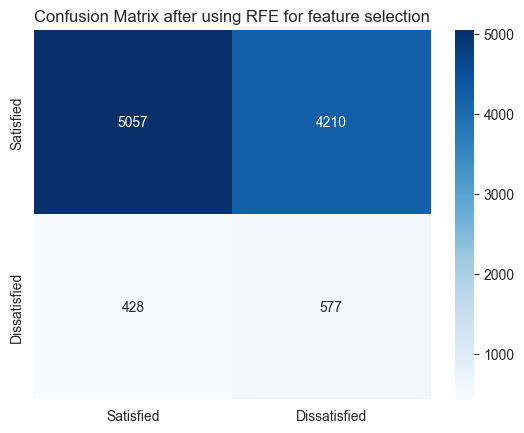

In [62]:
# RFE features selection
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

rfe = RFE(XGBClassifier(
    max_depth = 1,
    min_child_weight = 3,      
    reg_lambda = 1,
    learning_rate = 0.1,      
    subsample=1,
    colsample_bytree=1, 
    eval_metric='auc',     
    scale_pos_weight = scale_pos_weight),
    n_features_to_select=10)

rfe.fit(X_train, y_train)
selected_features = rfe.get_support(indices=True)
print(f'RFE selected {len(feature_cols[selected_features])} features\n')
print('Selected features by RFE:\n', feature_cols[selected_features])

model.fit(X_train[:, selected_features], y_train)
y_pred = model.predict(X_test[:, selected_features])
print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Dissatisfied'], yticklabels=['Satisfied', 'Dissatisfied'])
plt.title('Confusion Matrix after using RFE for feature selection')
# print(model.score(X_train[:, selected_features], y_train))
# f1_score

# Conclusion and Next Steps

## Conclusion:
This analysis revealed that predicting customer dissatisfaction using the current dataset poses significant challenges due to **high class overlap**, **imbalanced data**, and **insufficient feature granularity**. Despite applying several machine learning models and extensive feature engineering, the classification results (57% recall, 12% precision) remain suboptimal, largely due to limitations in the available data. Key issues such as **gender imbalance**, **survey context differences**, and **data anomalies** further hinder model performance and fairness.

## Next Steps:
1. **Data Collection Improvement**: Revise the data collection process to gather more granular behavioral signals, including **customer interaction metrics** (e.g., support contact frequency, browsing activity) and **demographic data**. This will enhance the model's ability to differentiate between satisfied and dissatisfied customers.
   
2. **Bias and Fairness Audits**: Investigate potential biases related to gender and survey context imbalances. Implement fairness audits to ensure that the model can generalize well across different customer groups.

3. **Segmentation and Hybrid Models**: Explore **clustering techniques** to segment users based on behavioral and demographic characteristics. Consider building hybrid models tailored to these segments to improve predictive accuracy.

4. **Time-Series and Anomaly Detection**: With more detailed time-based data, explore **time-series models** (e.g., LSTM) and **anomaly detection methods** (e.g., Isolation Forest) to capture shifts in customer behavior that may predict dissatisfaction.

5. **Revisit Model Evaluation**: As new features are incorporated and biases are addressed, re-evaluate the models using more suitable metrics (e.g., AUC-ROC, precision-recall curves) to better reflect the business goals of improving customer satisfaction and retention.

By implementing these steps, we can significantly enhance our ability to predict dissatisfaction and take timely actions to improve customer retention.